Public code for submitted paper "DMBGN: Deep Multi-Behavior Graph Networks for Voucher Redemption Rate Prediction" for SIGKDD 2021. This code covers the experimental results in Chapter 5 in the submitted paper. Note that the following experiments are conducted on a randomly desensitized sampled dataset from original dataset (Region C) mentioned in the paper, all related id features are hashed for public use.

This notebook is organized into 5 parts:
1. Data Processing: generate the training data from the original log table (for log description, please refer to README.md file under ./data directory
2. Baseline Models: corresponding to 5 baseline models compared in the submitted paper, including LR, GBDT, DNN, WDL and DIN model.
3. Proposed Method: DMBGN: our proposed model, which includes experiment 2 variants of DMBGN (AvgPooling and Pretrained) with our final model DMBGN
4. Summary: a summary of experiment results
5. Reference

The content of this notebook is as:
- 1 Data Processing
  - 1.1 Logs Processing
  - 1.2 Label Encoding and Normalization
- 2 Baseline Models
  - 2.1 LR
  - 2.2 GBDT
  - 2.3 DNN
  - 2.4 WDL
  - 2.5 DIN
- 3 Proposed Method: DMBGN
  - 3.1 DMBGN-AvgPooling
  - 3.2 DMBGN-Pretrained
    - 3.2.1 UVG Graphs
    - 3.2.2 GNN Networks
      - 3.2.2.1 Get Pretrained Item Embedding
      - 3.2.2.2 Train GNN
      - 3.2.2.3 Generate Pretrained UVG Embedding
      - 3.2.2.4 GMBDN Log Processing
  - 3.3 DMBGN
- 4 Summary
- 5 Reference


Note that you can run all codes directly for all the results. For DMBGN it might takes a longer time and we used 8 GPUs for accerlation purpose.


Author: \
    Lin Li (boolean.ll@alibaba-inc.com) \
    Fengtong Xiao (fengtong.xiao@alibaba-inc.com) \
    Weinan Xu (stella.xu@lazada.com)

References: \
    DMBGN: Deep Multi-Behavior Graph Networks for Voucher Redemption Rate Prediction

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

import numpy as np
import pandas as pd
import pandasql as ps

import warnings
import logging
import sys
import pickle
import csv
import os

from datetime import datetime, timedelta
from sklearn.metrics import log_loss, roc_auc_score
from prettytable import PrettyTable

import torch
from deepctr_torch.inputs import SparseFeat, DenseFeat,VarLenSparseFeat, get_feature_names
from deepctr_torch.models import *
from tqdm import tqdm

sys.setrecursionlimit(9000000) 
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s]: %(message)s')
warnings.filterwarnings('ignore')

from models.util import *
from models import *

In [2]:
def get_device(idx=0):
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    return device
device_count = torch.cuda.device_count()
device = get_device()
device

device(type='cuda')

# Data Processing

In [3]:
# Load the pickle file, note you might need to unzip the kdd_data.pkl.zip to recover the pkl file
# To unzip, use the following linux commands:
# $ cd ./data
# $ unzip kdd_data.pkl.zip

file_path = './data/kdd_data.pkl'
with open(file_path, "rb") as f:
    log_df = pickle.load(f)
    session_df = pickle.load(f)
    item_df = pickle.load(f)
log_df.shape, session_df.shape, item_df.shape

((62068, 19), (1118593, 14), (286735, 6))

##  Logs Processing
construct the historical UVG sequence following the chronological order 


In [4]:
log_df

,session_id,label,user_id,promotion_id,voucher_min_spend,voucher_discount,voucher_collect_time,voucher_redeem_time,campaign_name,user_age_level,user_gender,user_purchase_level,user_trd__orders_cnt_hist,user_trd__actual_gmv_usd_hist,user_trd__orders_cnt_platform_discount_hist,user_trd__max_gmv_usd_hist,user_trd__avg_gmv_usd_hist,user_trd__min_gmv_usd_hist,dtype
0,12130_38,1,12130,38,888,80,14363,28292,C3,5.0,1,8.0,52.0,706.648652,4.0,79.950388,11.584404,0.827519,train
1,12130_85,0,12130,85,4999,500,49983,49983,C2,5.0,1,8.0,69.0,822.218764,9.0,60.165341,8.747008,0.601405,test
2,12156_64,0,12156,64,7799,700,21441,21441,C3,4.0,0,9.0,26.0,349.797257,4.0,118.703723,8.531640,0.928380,test
3,12156_91,1,12156,91,799,80,46418,52254,C2,4.0,0,9.0,61.0,793.370613,7.0,215.294128,7.778143,0.517295,test
4,12156_310,1,12156,310,349,30,121387,131549,C1,4.0,0,9.0,65.0,842.410759,8.0,215.294128,7.589286,0.517295,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62063,11873_319,0,11873,319,1999,200,120575,120575,C1,2.0,1,9.0,18.0,884.002906,16.0,260.133633,21.047688,0.000000,train
62064,11873_305,1,11873,305,4999,500,120576,131797,C1,2.0,1,9.0,18.0,884.002906,16.0,260.133633,21.047688,0.000000,train
62065,11879_159,0,11879,159,799,70,72071,72071,C0,4.0,0,8.0,10.0,340.424720,1.0,53.094769,28.368727,3.595659,test
62066,11880_38,0,11880,38,888,80,3867,4451,C3,2.0,1,9.0,169.0,5085.468023,24.0,501.537557,14.009554,0.000000,train


In [5]:
q1 = "select *, ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY CAST(voucher_collect_time AS BIGINT) ASC) as rk from {logdf}".format(logdf="log_df")
log_df = ps.sqldf(q1, locals())

In [6]:
sql = " SELECT L.* \
            , coalesce(R.session_id, '') AS hist_session_id \
            , coalesce(R.promotion_id, '') AS hist_promotion_id \
            , coalesce(R.rk, '') AS hist_rk \
            , R.voucher_collect_time AS hist_voucher_collect_time \
        FROM {df} L \
        LEFT JOIN {df} R \
        ON L.user_id = R.user_id \
        AND L.session_id != R.session_id \
        AND L.campaign_name != R.campaign_name \
        AND R.label = 1 \
        AND L.rk > R.rk \
        ORDER BY L.rk ASC, R.rk ASC".format(df='log_df')
log_df_tmp = ps.sqldf(sql, locals())
log_df_tmp

,session_id,label,user_id,promotion_id,voucher_min_spend,voucher_discount,voucher_collect_time,voucher_redeem_time,campaign_name,user_age_level,...,user_trd__orders_cnt_platform_discount_hist,user_trd__max_gmv_usd_hist,user_trd__avg_gmv_usd_hist,user_trd__min_gmv_usd_hist,dtype,rk,hist_session_id,hist_promotion_id,hist_rk,hist_voucher_collect_time
0,0_82,0,0,82,299,30,45451,45521,C2,4.0,...,0.0,6.376755,3.917888,2.518198,train,1,,,,None
1,1_425,0,1,425,40,4,100489,132869,C1,0.0,...,1.0,27.976711,8.408431,0.739039,train,1,,,,None
2,10_82,0,10,82,299,30,46827,48182,C2,NaN,...,0.0,4.972645,3.039102,1.498169,train,1,,,,None
3,100_82,0,100,82,299,30,46227,46227,C2,3.0,...,34.0,397.755770,17.843147,0.003525,train,1,,,,None
4,1000_386,0,1000,386,0,60,96836,96836,C1,3.0,...,0.0,0.000000,0.000000,0.000000,train,1,,,,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83457,6777_391,0,6777,391,199,30,128346,128346,C1,4.0,...,50.0,93.471440,7.419820,0.000000,train,102,6777_248,248,39,74788
83458,6777_383,0,6777,383,500,50,128346,128346,C1,4.0,...,50.0,93.471440,7.419820,0.000000,train,103,6777_138,138,2,39379
83459,6777_383,0,6777,383,500,50,128346,128346,C1,4.0,...,50.0,93.471440,7.419820,0.000000,train,103,6777_206,206,17,59004
83460,6777_383,0,6777,383,500,50,128346,128346,C1,4.0,...,50.0,93.471440,7.419820,0.000000,train,103,6777_215,215,27,64992


In [7]:
user_voucher_log = log_df_tmp.groupby([ 'session_id', 'label', 'user_id', 'promotion_id', 'voucher_min_spend', 
                       'voucher_discount', 'voucher_collect_time', 'voucher_redeem_time',
                       'user_age_level', 'user_gender', 'user_purchase_level',
                       'user_trd__orders_cnt_hist', 'user_trd__actual_gmv_usd_hist',
                       'user_trd__orders_cnt_platform_discount_hist',
                       'user_trd__max_gmv_usd_hist', 'user_trd__avg_gmv_usd_hist',
                       'user_trd__min_gmv_usd_hist', 'dtype']) \
                .agg({'hist_session_id': lambda x: "%s" % ','.join(x),
                      'hist_promotion_id': lambda x: "%s" % ','.join(x),
                      'hist_rk': lambda x: list(x),
                      'hist_voucher_collect_time': "count"}).reset_index()

user_voucher_log['keys_length'] = user_voucher_log['hist_voucher_collect_time']
user_voucher_log = user_voucher_log.drop(columns=['hist_rk', 'hist_voucher_collect_time'])

In [8]:
user_voucher_log

,session_id,label,user_id,promotion_id,voucher_min_spend,voucher_discount,voucher_collect_time,voucher_redeem_time,user_age_level,user_gender,...,user_trd__orders_cnt_hist,user_trd__actual_gmv_usd_hist,user_trd__orders_cnt_platform_discount_hist,user_trd__max_gmv_usd_hist,user_trd__avg_gmv_usd_hist,user_trd__min_gmv_usd_hist,dtype,hist_session_id,hist_promotion_id,keys_length
0,0_82,0,0,82,299,30,45451,45521,4.0,0,...,4.0,23.507327,0.0,6.376755,3.917888,2.518198,train,,,0
1,10000_38,0,10000,38,888,80,13253,13254,3.0,0,...,6.0,218.105824,9.0,42.643151,12.116990,3.581674,train,,,0
2,10001_159,1,10001,159,799,70,80001,89306,0.0,0,...,39.0,373.530611,3.0,32.090705,6.225510,0.561611,train,,,0
3,10001_319,0,10001,319,1999,200,115663,115663,0.0,0,...,42.0,381.810513,3.0,32.090705,5.614860,0.487420,train,10001_159,159,1
4,10001_38,0,10001,38,888,80,12867,19625,0.0,0,...,11.0,133.172685,0.0,26.419591,11.097724,1.811817,train,,,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58046,99_82,0,99,82,299,30,46577,46577,3.0,0,...,44.0,2462.818244,50.0,329.698604,18.944756,0.000000,train,,,0
58047,99_83,1,99,83,1999,200,35523,53242,3.0,0,...,43.0,2397.249462,46.0,329.698604,19.025789,0.000000,test,,,0
58048,99_91,0,99,91,799,80,35523,46578,3.0,0,...,43.0,2397.249462,46.0,329.698604,19.025789,0.000000,train,,,0
58049,9_61,1,9,61,2999,300,24981,28017,3.0,1,...,22.0,715.893947,23.0,150.129713,9.419657,1.116494,train,,,0


In [9]:
# a statistics of historical UVG sequence distribution
user_voucher_log.groupby(['keys_length']).agg({'session_id': "count"}).reset_index()

,keys_length,session_id
0,0,39908
1,1,8720
2,2,4236
3,3,2326
4,4,1325
5,5,721
6,6,267
7,7,218
8,8,115
9,9,72


## Label Encoding and Normalization
Label encoding for sparse features and normlaization for dense features

In [10]:
df = user_voucher_log.copy()
df = df.take(np.random.permutation(len(df)))

In [11]:
sparse_feature = ['promotion_id','session_id','user_gender','user_age_level','user_purchase_level'] #['promotion_id','voucher_min_spend','voucher_discount_amount']

hist_list_features = ['hist_promotion_id','hist_session_id','keys_length']

ignore_features=['dtype','venture','ds','user_id','label','voucher_collect_time','voucher_redeem_time','campaign_name','rk']
ignore_features_key_words = ['out', 'emb']

dense_feature = []
train_features = []

for feat in df.columns:
    flag = True 
    for key in ignore_features_key_words:
        if key in feat:
            flag = False
            break
    if feat not in ignore_features and flag is True:
        if feat not in hist_list_features:
            train_features.append(feat)
        if feat not in sparse_feature and feat not in hist_list_features:
            dense_feature.append(feat)

target = 'label'
df[['session_id','promotion_id','user_gender','user_age_level','user_purchase_level']]=df[['session_id','promotion_id','user_gender','user_age_level','user_purchase_level']].astype('str')

In [12]:
label_encoder = {}
for feat in sparse_feature:
    df[feat] = df[feat].fillna(0)
    print("lbe {}".format(feat))
    
    lbe = LabelEncoderExt()
    lbe.fit(df[feat])
        
    df[feat] = lbe.transform(df[feat])
    label_encoder[feat] = lbe
    logging.warn('LabelEncoder encoding ' + feat + " len " + str(len(lbe)))
print("done")

2021-06-01 18:17:13,783 [WARNING]: LabelEncoder encoding promotion_id len 462


lbe promotion_id
LabelEncoderExt fitting...
LabelEncoderExt transforming...
lbe session_id
LabelEncoderExt fitting...
LabelEncoderExt transforming...


2021-06-01 18:17:14,019 [WARNING]: LabelEncoder encoding session_id len 58052
2021-06-01 18:17:14,104 [WARNING]: LabelEncoder encoding user_gender len 4
2021-06-01 18:17:14,177 [WARNING]: LabelEncoder encoding user_age_level len 10


lbe user_gender
LabelEncoderExt fitting...
LabelEncoderExt transforming...
lbe user_age_level
LabelEncoderExt fitting...
LabelEncoderExt transforming...
lbe user_purchase_level
LabelEncoderExt fitting...
LabelEncoderExt transforming...


2021-06-01 18:17:14,251 [WARNING]: LabelEncoder encoding user_purchase_level len 12


done


In [13]:
mean_kv = {}
std_kv = {}
for feat in dense_feature:
    print(feat)
    mean_kv[feat] = df[feat].mean()
    std_kv[feat] = df[feat].std()
    df[feat] = (df[feat] - mean_kv[feat]) / std_kv[feat]

voucher_min_spend
voucher_discount
user_trd__orders_cnt_hist
user_trd__actual_gmv_usd_hist
user_trd__orders_cnt_platform_discount_hist
user_trd__max_gmv_usd_hist
user_trd__avg_gmv_usd_hist
user_trd__min_gmv_usd_hist


In [14]:
deep_ctr_df = df 

dctr_train = deep_ctr_df[deep_ctr_df.dtype == 'train']
dctr_v1 = deep_ctr_df[deep_ctr_df.dtype == 'test']

# Baseline Models

In [15]:
results={}

In [16]:
embedding_dim = 16
sparse_feature_columns = [SparseFeat(feat, len(label_encoder[feat].classes_), embedding_dim = embedding_dim) for feat in sparse_feature]
dense_feature_columns = [DenseFeat(feat, 1, ) for feat in dense_feature]

dnn_feature_columns = sparse_feature_columns + dense_feature_columns
linear_feature_columns = sparse_feature_columns + dense_feature_columns

## LR
LR: Logistic Regression [1] is a shallow model.

In [17]:
def gen_model_input_data(feature_names, raw_features, target):
    model_input = {}
    for name in feature_names:
        if name in sparse_feature:
            model_input[name] = raw_features[name]
        else:
            model_input[name] = raw_features[name].fillna(0).astype(np.float32)
    return raw_features[target], model_input

feature_names = get_feature_names(dense_feature_columns + sparse_feature_columns)
train_label, train_model_input = gen_model_input_data(feature_names, dctr_train, target)
test_label1, test_model_input1 = gen_model_input_data(feature_names, dctr_v1, target)

In [18]:
model_name = 'LR'
epoch = 50
batch_size = 300

model = WDL(linear_feature_columns=dnn_feature_columns,
            dnn_feature_columns=[], 
            dnn_use_bn=True,
            l2_reg_dnn=0.1, 
            l2_reg_embedding = 0.0001, 
            dnn_hidden_units=(128,64), 
            init_std=1, 
            dnn_dropout=0.5, 
            task='binary', 
            dnn_activation='relu', 
            device=device)

model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.1, amsgrad=True)
model.compile(optimizer, 'binary_crossentropy',metrics=['auc','logloss'])
res, pred1 = model.fit(train_model_input,  train_label.values.astype(int), batch_size=batch_size, epochs=epoch, validation_data=(test_model_input1,test_label1),verbose=1)

results[model_name] = model, res, pred1, test_label1

12it [00:00, 117.94it/s]

cuda
Train on 46361 samples, validate on 11690 samples, 155 steps per epoch


155it [00:01, 133.07it/s]
14it [00:00, 131.15it/s]

Epoch 1/50
1s - loss:  0.5970 - auc:  0.5655 - logloss:  0.5947 - val_auc:  0.6099 - val_logloss:  0.5215


155it [00:01, 133.92it/s]
14it [00:00, 131.39it/s]

Epoch 2/50
1s - loss:  0.4861 - auc:  0.7432 - logloss:  0.4839 - val_auc:  0.6739 - val_logloss:  0.4591


155it [00:01, 133.99it/s]
14it [00:00, 131.25it/s]

Epoch 3/50
1s - loss:  0.4459 - auc:  0.7680 - logloss:  0.4438 - val_auc:  0.7053 - val_logloss:  0.4361


155it [00:01, 133.98it/s]
14it [00:00, 131.40it/s]

Epoch 4/50
1s - loss:  0.4297 - auc:  0.7746 - logloss:  0.4276 - val_auc:  0.7201 - val_logloss:  0.4257


155it [00:01, 122.51it/s]
14it [00:00, 130.74it/s]

Epoch 5/50
1s - loss:  0.4211 - auc:  0.7735 - logloss:  0.4194 - val_auc:  0.7267 - val_logloss:  0.4193


155it [00:01, 133.23it/s]
11it [00:00, 104.85it/s]

Epoch 6/50
1s - loss:  0.4152 - auc:  0.7716 - logloss:  0.4133 - val_auc:  0.7295 - val_logloss:  0.4146


155it [00:01, 129.37it/s]
11it [00:00, 104.99it/s]

Epoch 7/50
1s - loss:  0.4106 - auc:  0.7699 - logloss:  0.4084 - val_auc:  0.7308 - val_logloss:  0.4108


155it [00:01, 129.62it/s]
11it [00:00, 105.08it/s]

Epoch 8/50
1s - loss:  0.4068 - auc:  0.7679 - logloss:  0.4047 - val_auc:  0.7319 - val_logloss:  0.4077


155it [00:01, 129.68it/s]
11it [00:00, 105.15it/s]

Epoch 9/50
1s - loss:  0.4037 - auc:  0.7663 - logloss:  0.4016 - val_auc:  0.7323 - val_logloss:  0.4052


155it [00:01, 129.46it/s]
11it [00:00, 101.99it/s]

Epoch 10/50
1s - loss:  0.4011 - auc:  0.7656 - logloss:  0.3995 - val_auc:  0.7328 - val_logloss:  0.4030


155it [00:01, 130.56it/s]
14it [00:00, 131.89it/s]

Epoch 11/50
1s - loss:  0.3989 - auc:  0.7639 - logloss:  0.3968 - val_auc:  0.7333 - val_logloss:  0.4012


155it [00:01, 134.44it/s]
14it [00:00, 131.97it/s]

Epoch 12/50
1s - loss:  0.3971 - auc:  0.7635 - logloss:  0.3953 - val_auc:  0.7338 - val_logloss:  0.3997


155it [00:01, 134.61it/s]
14it [00:00, 132.14it/s]

Epoch 13/50
1s - loss:  0.3956 - auc:  0.7627 - logloss:  0.3935 - val_auc:  0.7342 - val_logloss:  0.3985


155it [00:01, 134.29it/s]
14it [00:00, 132.14it/s]

Epoch 14/50
1s - loss:  0.3943 - auc:  0.7622 - logloss:  0.3926 - val_auc:  0.7345 - val_logloss:  0.3974


155it [00:01, 135.17it/s]
14it [00:00, 132.35it/s]

Epoch 15/50
1s - loss:  0.3932 - auc:  0.7625 - logloss:  0.3913 - val_auc:  0.7348 - val_logloss:  0.3965


155it [00:01, 122.38it/s]
14it [00:00, 132.35it/s]

Epoch 16/50
1s - loss:  0.3922 - auc:  0.7627 - logloss:  0.3902 - val_auc:  0.7351 - val_logloss:  0.3957


155it [00:01, 135.23it/s]
14it [00:00, 132.58it/s]

Epoch 17/50
1s - loss:  0.3914 - auc:  0.7622 - logloss:  0.3895 - val_auc:  0.7354 - val_logloss:  0.3950


155it [00:01, 135.26it/s]
14it [00:00, 132.79it/s]

Epoch 18/50
1s - loss:  0.3907 - auc:  0.7616 - logloss:  0.3890 - val_auc:  0.7356 - val_logloss:  0.3944


155it [00:01, 135.48it/s]
14it [00:00, 132.40it/s]

Epoch 19/50
1s - loss:  0.3901 - auc:  0.7615 - logloss:  0.3881 - val_auc:  0.7358 - val_logloss:  0.3939


155it [00:01, 135.07it/s]
14it [00:00, 132.65it/s]

Epoch 20/50
1s - loss:  0.3896 - auc:  0.7615 - logloss:  0.3877 - val_auc:  0.7360 - val_logloss:  0.3934


155it [00:01, 123.49it/s]
14it [00:00, 132.17it/s]

Epoch 21/50
1s - loss:  0.3891 - auc:  0.7606 - logloss:  0.3872 - val_auc:  0.7361 - val_logloss:  0.3930


155it [00:01, 135.09it/s]
14it [00:00, 132.25it/s]

Epoch 22/50
1s - loss:  0.3887 - auc:  0.7612 - logloss:  0.3867 - val_auc:  0.7363 - val_logloss:  0.3926


155it [00:01, 134.89it/s]
14it [00:00, 132.57it/s]

Epoch 23/50
1s - loss:  0.3884 - auc:  0.7599 - logloss:  0.3864 - val_auc:  0.7364 - val_logloss:  0.3923


155it [00:01, 135.20it/s]
14it [00:00, 132.82it/s]

Epoch 24/50
1s - loss:  0.3881 - auc:  0.7604 - logloss:  0.3862 - val_auc:  0.7365 - val_logloss:  0.3920


155it [00:01, 135.18it/s]
14it [00:00, 132.88it/s]

Epoch 25/50
1s - loss:  0.3878 - auc:  0.7607 - logloss:  0.3856 - val_auc:  0.7367 - val_logloss:  0.3918


155it [00:01, 135.34it/s]
14it [00:00, 131.75it/s]

Epoch 26/50
1s - loss:  0.3875 - auc:  0.7608 - logloss:  0.3858 - val_auc:  0.7368 - val_logloss:  0.3916


155it [00:01, 134.90it/s]
13it [00:00, 129.96it/s]

Epoch 27/50
1s - loss:  0.3873 - auc:  0.7606 - logloss:  0.3852 - val_auc:  0.7368 - val_logloss:  0.3914


155it [00:01, 134.97it/s]
14it [00:00, 130.41it/s]

Epoch 28/50
1s - loss:  0.3871 - auc:  0.7607 - logloss:  0.3854 - val_auc:  0.7369 - val_logloss:  0.3912


155it [00:01, 135.02it/s]
14it [00:00, 130.71it/s]

Epoch 29/50
1s - loss:  0.3869 - auc:  0.7603 - logloss:  0.3848 - val_auc:  0.7370 - val_logloss:  0.3911


155it [00:01, 134.71it/s]
14it [00:00, 130.30it/s]

Epoch 30/50
1s - loss:  0.3868 - auc:  0.7601 - logloss:  0.3849 - val_auc:  0.7370 - val_logloss:  0.3909


155it [00:01, 134.75it/s]
14it [00:00, 130.22it/s]

Epoch 31/50
1s - loss:  0.3866 - auc:  0.7607 - logloss:  0.3847 - val_auc:  0.7371 - val_logloss:  0.3908


155it [00:01, 122.69it/s]
13it [00:00, 129.68it/s]

Epoch 32/50
1s - loss:  0.3865 - auc:  0.7598 - logloss:  0.3846 - val_auc:  0.7371 - val_logloss:  0.3907


155it [00:01, 134.75it/s]
14it [00:00, 130.41it/s]

Epoch 33/50
1s - loss:  0.3864 - auc:  0.7601 - logloss:  0.3844 - val_auc:  0.7373 - val_logloss:  0.3906


155it [00:01, 134.63it/s]
13it [00:00, 129.42it/s]

Epoch 34/50
1s - loss:  0.3863 - auc:  0.7607 - logloss:  0.3844 - val_auc:  0.7373 - val_logloss:  0.3905


155it [00:01, 135.00it/s]
14it [00:00, 132.56it/s]

Epoch 35/50
1s - loss:  0.3861 - auc:  0.7609 - logloss:  0.3843 - val_auc:  0.7373 - val_logloss:  0.3904


155it [00:01, 135.14it/s]
14it [00:00, 132.75it/s]

Epoch 36/50
1s - loss:  0.3861 - auc:  0.7603 - logloss:  0.3841 - val_auc:  0.7373 - val_logloss:  0.3903


155it [00:01, 123.16it/s]
13it [00:00, 129.94it/s]

Epoch 37/50
1s - loss:  0.3860 - auc:  0.7610 - logloss:  0.3844 - val_auc:  0.7374 - val_logloss:  0.3902


155it [00:01, 131.71it/s]
14it [00:00, 130.99it/s]

Epoch 38/50
1s - loss:  0.3859 - auc:  0.7601 - logloss:  0.3842 - val_auc:  0.7374 - val_logloss:  0.3902


155it [00:01, 133.93it/s]
14it [00:00, 131.11it/s]

Epoch 39/50
1s - loss:  0.3859 - auc:  0.7609 - logloss:  0.3839 - val_auc:  0.7375 - val_logloss:  0.3901


155it [00:01, 134.28it/s]
14it [00:00, 131.74it/s]

Epoch 40/50
1s - loss:  0.3858 - auc:  0.7607 - logloss:  0.3839 - val_auc:  0.7375 - val_logloss:  0.3900


155it [00:01, 134.24it/s]
14it [00:00, 131.43it/s]

Epoch 41/50
1s - loss:  0.3857 - auc:  0.7597 - logloss:  0.3836 - val_auc:  0.7375 - val_logloss:  0.3900


155it [00:01, 134.29it/s]
13it [00:00, 129.58it/s]

Epoch 42/50
1s - loss:  0.3857 - auc:  0.7601 - logloss:  0.3836 - val_auc:  0.7376 - val_logloss:  0.3900


155it [00:01, 133.79it/s]
14it [00:00, 131.39it/s]

Epoch 43/50
1s - loss:  0.3856 - auc:  0.7604 - logloss:  0.3836 - val_auc:  0.7376 - val_logloss:  0.3899


155it [00:01, 134.07it/s]
14it [00:00, 131.49it/s]

Epoch 44/50
1s - loss:  0.3856 - auc:  0.7598 - logloss:  0.3837 - val_auc:  0.7375 - val_logloss:  0.3899


155it [00:01, 134.18it/s]
14it [00:00, 131.44it/s]

Epoch 45/50
1s - loss:  0.3856 - auc:  0.7602 - logloss:  0.3835 - val_auc:  0.7376 - val_logloss:  0.3898


155it [00:01, 133.18it/s]
14it [00:00, 130.81it/s]

Epoch 46/50
1s - loss:  0.3855 - auc:  0.7602 - logloss:  0.3835 - val_auc:  0.7376 - val_logloss:  0.3898


155it [00:01, 133.90it/s]
14it [00:00, 131.40it/s]

Epoch 47/50
1s - loss:  0.3855 - auc:  0.7602 - logloss:  0.3834 - val_auc:  0.7377 - val_logloss:  0.3898


155it [00:01, 122.43it/s]
14it [00:00, 131.06it/s]

Epoch 48/50
1s - loss:  0.3854 - auc:  0.7605 - logloss:  0.3835 - val_auc:  0.7376 - val_logloss:  0.3898


155it [00:01, 133.96it/s]
14it [00:00, 131.05it/s]

Epoch 49/50
1s - loss:  0.3854 - auc:  0.7600 - logloss:  0.3832 - val_auc:  0.7376 - val_logloss:  0.3897


155it [00:01, 134.03it/s]

Epoch 50/50
1s - loss:  0.3854 - auc:  0.7609 - logloss:  0.3834 - val_auc:  0.7377 - val_logloss:  0.3897


## GBDT
GBDT: Gradient Boosting Decision Tree [2] is used to assess the performance of non deep-learning algorithms. Only dense features are used.

In [19]:
import xgboost as xgb
model_name = "xgBoost"
xgb_data_train = dctr_train
df_xgb_train =  xgb.DMatrix(xgb_data_train[dense_feature], 
                            label=xgb_data_train[target])

xgb_data_test1 = dctr_v1
df_xgb_test1 = xgb.DMatrix(xgb_data_test1[dense_feature],
                            label=xgb_data_test1[target])

params = {'objective': 'binary:logistic',
          'eval_metric': ['auc', 'logloss'],
          'learning_rate': 0.06,
          'num_leaves':256,
          'max_depth':7,
          'max_bin':64}

evallist = [(df_xgb_test1, 'eval'), (df_xgb_train, 'train')]
num_boost_round = 130
xgb = xgb.train(params,
                df_xgb_train,
                num_boost_round,
                evallist) 

xgb_pred_v1 = xgb.predict(df_xgb_test1)
xgb_label_v1 = xgb_data_test1[target]
auc_t1 = roc_auc_score(xgb_label_v1, xgb_pred_v1)
logloss_t1 = log_loss(xgb_label_v1, xgb_pred_v1)
res = {'eval_auc':auc_t1, "eval_logloss":logloss_t1}

results[model_name] = xgb, res, xgb_pred_v1, xgb_label_v1

[21:28:44] WARNING: ../src/learner.cc:541: 
Parameters: { num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	eval-auc:0.74426	eval-logloss:0.66234	train-auc:0.75173	train-logloss:0.66225
[1]	eval-auc:0.74628	eval-logloss:0.63497	train-auc:0.75559	train-logloss:0.63484
[2]	eval-auc:0.74539	eval-logloss:0.61074	train-auc:0.75743	train-logloss:0.61042
[3]	eval-auc:0.74809	eval-logloss:0.58899	train-auc:0.76167	train-logloss:0.58850
[4]	eval-auc:0.74831	eval-logloss:0.56951	train-auc:0.76250	train-logloss:0.56880
[5]	eval-auc:0.74857	eval-logloss:0.55195	train-auc:0.76321	train-logloss:0.55111
[6]	eval-auc:0.74915	eval-logloss:0.53605	train-auc:0.76352	train-logloss:0.53516
[7]	eval-auc:0.74995	eval-logloss:0.52171	train-auc:0.76406	train-logloss:0.52070
[8]	eval-auc:0

## DNN
The Deep Neural Network is used as the first baseline taking both dense features and embedding of sparse id features into the model.

In [20]:
model_name = 'DNN'
epoch = 20
batch_size = 300

model = WDL(linear_feature_columns=[], 
            dnn_feature_columns=dnn_feature_columns, 
            dnn_use_bn=True,
            l2_reg_dnn=0.1, 
            l2_reg_embedding = 0.0001, 
            dnn_hidden_units=(128,64), 
            init_std=1, 
            dnn_dropout=0.5, 
            task='binary', 
            dnn_activation='relu', 
            device=device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.1, amsgrad=True)
model.compile(optimizer, 'binary_crossentropy',metrics=['auc','logloss'])
res, pred1 = model.fit(train_model_input,  train_label.values.astype(int), batch_size=batch_size, epochs=epoch, validation_data=(test_model_input1,test_label1),verbose=1)

results[model_name] = model, res, pred1, test_label1

6it [00:00, 59.84it/s]

cuda
Train on 46361 samples, validate on 11690 samples, 155 steps per epoch


155it [00:01, 92.25it/s]
7it [00:00, 67.98it/s]

Epoch 1/20
1s - loss:  7.3257 - auc:  0.5278 - logloss:  0.4861 - val_auc:  0.6165 - val_logloss:  0.4496


155it [00:01, 94.73it/s]
7it [00:00, 67.33it/s]

Epoch 2/20
1s - loss:  7.2642 - auc:  0.6431 - logloss:  0.4250 - val_auc:  0.6737 - val_logloss:  0.4151


155it [00:01, 87.60it/s]
7it [00:00, 67.28it/s]

Epoch 3/20
1s - loss:  7.2522 - auc:  0.6827 - logloss:  0.4130 - val_auc:  0.6969 - val_logloss:  0.4077


155it [00:01, 94.01it/s]
7it [00:00, 67.87it/s]

Epoch 4/20
1s - loss:  7.2452 - auc:  0.7044 - logloss:  0.4058 - val_auc:  0.7109 - val_logloss:  0.4019


155it [00:01, 94.08it/s]
7it [00:00, 68.01it/s]

Epoch 5/20
1s - loss:  7.2395 - auc:  0.7190 - logloss:  0.4001 - val_auc:  0.7221 - val_logloss:  0.3969


155it [00:01, 94.26it/s]
7it [00:00, 68.02it/s]

Epoch 6/20
1s - loss:  7.2347 - auc:  0.7288 - logloss:  0.3954 - val_auc:  0.7309 - val_logloss:  0.3931


155it [00:01, 94.26it/s]
7it [00:00, 67.65it/s]

Epoch 7/20
1s - loss:  7.2311 - auc:  0.7377 - logloss:  0.3917 - val_auc:  0.7375 - val_logloss:  0.3899


155it [00:01, 88.23it/s]
7it [00:00, 67.40it/s]

Epoch 8/20
1s - loss:  7.2283 - auc:  0.7421 - logloss:  0.3890 - val_auc:  0.7418 - val_logloss:  0.3877


155it [00:01, 94.00it/s]
7it [00:00, 67.13it/s]

Epoch 9/20
1s - loss:  7.2263 - auc:  0.7466 - logloss:  0.3871 - val_auc:  0.7454 - val_logloss:  0.3870


155it [00:01, 94.14it/s]
7it [00:00, 67.84it/s]

Epoch 10/20
1s - loss:  7.2250 - auc:  0.7492 - logloss:  0.3857 - val_auc:  0.7482 - val_logloss:  0.3847


155it [00:01, 94.25it/s]
7it [00:00, 67.84it/s]

Epoch 11/20
1s - loss:  7.2238 - auc:  0.7509 - logloss:  0.3845 - val_auc:  0.7502 - val_logloss:  0.3838


155it [00:01, 94.15it/s]
7it [00:00, 67.39it/s]

Epoch 12/20
1s - loss:  7.2227 - auc:  0.7529 - logloss:  0.3836 - val_auc:  0.7518 - val_logloss:  0.3828


155it [00:01, 94.08it/s]
7it [00:00, 67.84it/s]

Epoch 13/20
1s - loss:  7.2219 - auc:  0.7547 - logloss:  0.3827 - val_auc:  0.7543 - val_logloss:  0.3822


155it [00:01, 87.87it/s]
7it [00:00, 67.89it/s]

Epoch 14/20
1s - loss:  7.2211 - auc:  0.7565 - logloss:  0.3816 - val_auc:  0.7553 - val_logloss:  0.3820


155it [00:01, 94.05it/s]
7it [00:00, 67.82it/s]

Epoch 15/20
1s - loss:  7.2203 - auc:  0.7579 - logloss:  0.3811 - val_auc:  0.7565 - val_logloss:  0.3803


155it [00:01, 94.13it/s]
7it [00:00, 68.35it/s]

Epoch 16/20
1s - loss:  7.2195 - auc:  0.7598 - logloss:  0.3803 - val_auc:  0.7577 - val_logloss:  0.3798


155it [00:01, 94.20it/s]
7it [00:00, 68.03it/s]

Epoch 17/20
1s - loss:  7.2188 - auc:  0.7599 - logloss:  0.3795 - val_auc:  0.7589 - val_logloss:  0.3793


155it [00:01, 93.94it/s]
7it [00:00, 67.67it/s]

Epoch 18/20
1s - loss:  7.2184 - auc:  0.7620 - logloss:  0.3792 - val_auc:  0.7594 - val_logloss:  0.3787


155it [00:01, 87.98it/s]
7it [00:00, 67.95it/s]

Epoch 19/20
1s - loss:  7.2177 - auc:  0.7622 - logloss:  0.3786 - val_auc:  0.7606 - val_logloss:  0.3784


155it [00:01, 93.22it/s]


Epoch 20/20
1s - loss:  7.2171 - auc:  0.7636 - logloss:  0.3779 - val_auc:  0.7618 - val_logloss:  0.3775


## WDL
Wide and Deep model [3] is widely accepted in real industrial applications. Compared with DNN, it has an additional linear model besides the deep model.

In [21]:
model_name = 'WDL'
epoch = 20
batch_size = 300

model = WDL(linear_feature_columns=linear_feature_columns, 
            dnn_feature_columns=dnn_feature_columns, 
            dnn_use_bn=True,
            l2_reg_dnn=0.1, 
            l2_reg_embedding = 0.0001, 
            dnn_hidden_units=(128,64), 
            init_std=1, 
            dnn_dropout=0.5, 
            task='binary', 
            dnn_activation='relu', 
            device=device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.05, amsgrad=True)
model.compile(optimizer, 'binary_crossentropy',metrics=['auc','logloss'])
res, pred1 = model.fit(train_model_input,  train_label.values.astype(int), batch_size=batch_size, epochs=epoch, validation_data=(test_model_input1,test_label1),verbose=1)

results[model_name] = model, res, pred1, test_label1

6it [00:00, 52.50it/s]

cuda
Train on 46361 samples, validate on 11690 samples, 155 steps per epoch


155it [00:02, 76.50it/s]
6it [00:00, 55.93it/s]

Epoch 1/20
2s - loss:  7.3530 - auc:  0.5151 - logloss:  0.5117 - val_auc:  0.6197 - val_logloss:  0.4439


155it [00:01, 78.37it/s]
6it [00:00, 55.79it/s]

Epoch 2/20
2s - loss:  7.2607 - auc:  0.6692 - logloss:  0.4193 - val_auc:  0.6896 - val_logloss:  0.4106


155it [00:01, 77.57it/s]
6it [00:00, 55.42it/s]

Epoch 3/20
2s - loss:  7.2444 - auc:  0.7211 - logloss:  0.4031 - val_auc:  0.7160 - val_logloss:  0.4015


155it [00:01, 78.17it/s]
6it [00:00, 55.89it/s]

Epoch 4/20
2s - loss:  7.2348 - auc:  0.7429 - logloss:  0.3937 - val_auc:  0.7300 - val_logloss:  0.3952


155it [00:01, 78.47it/s]
6it [00:00, 55.37it/s]

Epoch 5/20
2s - loss:  7.2280 - auc:  0.7573 - logloss:  0.3865 - val_auc:  0.7389 - val_logloss:  0.3906


155it [00:01, 78.48it/s]
6it [00:00, 56.19it/s]

Epoch 6/20
2s - loss:  7.2228 - auc:  0.7659 - logloss:  0.3815 - val_auc:  0.7452 - val_logloss:  0.3871


155it [00:01, 78.54it/s]
6it [00:00, 56.23it/s]

Epoch 7/20
2s - loss:  7.2187 - auc:  0.7714 - logloss:  0.3774 - val_auc:  0.7506 - val_logloss:  0.3841


155it [00:01, 78.61it/s]
6it [00:00, 56.54it/s]

Epoch 8/20
2s - loss:  7.2158 - auc:  0.7768 - logloss:  0.3744 - val_auc:  0.7539 - val_logloss:  0.3820


155it [00:01, 78.63it/s]
6it [00:00, 56.23it/s]

Epoch 9/20
2s - loss:  7.2134 - auc:  0.7800 - logloss:  0.3720 - val_auc:  0.7569 - val_logloss:  0.3808


155it [00:02, 74.26it/s]
6it [00:00, 56.40it/s]

Epoch 10/20
2s - loss:  7.2115 - auc:  0.7837 - logloss:  0.3702 - val_auc:  0.7590 - val_logloss:  0.3790


155it [00:01, 77.57it/s]
6it [00:00, 56.36it/s]

Epoch 11/20
2s - loss:  7.2099 - auc:  0.7861 - logloss:  0.3688 - val_auc:  0.7606 - val_logloss:  0.3783


155it [00:01, 77.92it/s]
6it [00:00, 55.87it/s]

Epoch 12/20
2s - loss:  7.2084 - auc:  0.7887 - logloss:  0.3671 - val_auc:  0.7622 - val_logloss:  0.3771


155it [00:01, 77.50it/s]
6it [00:00, 56.44it/s]

Epoch 13/20
2s - loss:  7.2073 - auc:  0.7902 - logloss:  0.3663 - val_auc:  0.7642 - val_logloss:  0.3762


155it [00:01, 78.06it/s]
6it [00:00, 55.52it/s]

Epoch 14/20
2s - loss:  7.2059 - auc:  0.7930 - logloss:  0.3647 - val_auc:  0.7651 - val_logloss:  0.3753


155it [00:02, 73.77it/s]
6it [00:00, 55.24it/s]

Epoch 15/20
2s - loss:  7.2049 - auc:  0.7941 - logloss:  0.3635 - val_auc:  0.7661 - val_logloss:  0.3747


155it [00:01, 78.32it/s]
6it [00:00, 55.75it/s]

Epoch 16/20
2s - loss:  7.2039 - auc:  0.7961 - logloss:  0.3629 - val_auc:  0.7675 - val_logloss:  0.3740


155it [00:01, 78.48it/s]
6it [00:00, 55.53it/s]

Epoch 17/20
2s - loss:  7.2030 - auc:  0.7978 - logloss:  0.3618 - val_auc:  0.7683 - val_logloss:  0.3735


155it [00:01, 78.06it/s]
6it [00:00, 55.65it/s]

Epoch 18/20
2s - loss:  7.2020 - auc:  0.7985 - logloss:  0.3608 - val_auc:  0.7688 - val_logloss:  0.3738


155it [00:01, 78.48it/s]
6it [00:00, 55.59it/s]

Epoch 19/20
2s - loss:  7.2009 - auc:  0.8016 - logloss:  0.3596 - val_auc:  0.7704 - val_logloss:  0.3727


155it [00:01, 78.38it/s]


Epoch 20/20
2s - loss:  7.1995 - auc:  0.8037 - logloss:  0.3582 - val_auc:  0.7716 - val_logloss:  0.3717


## DIN
Deep Interest Network [4] is an attention-based model in recommendation systems that has been proven successful in Alibaba. We use this as our second baseline, replacing the user’s historical item sequences with user’s historical voucher sequences to adapt to the VRR prediction task.

In [22]:
def get_xy_fd(dataset):
    print ("start generating x y data")
    
    dnn_feature_columns = []
    dnn_feature_columns += [SparseFeat(feat, len(label_encoder[feat]), embedding_dim = 16) 
                            for feat in ['session_id','user_gender','user_age_level','user_purchase_level', 'promotion_id']]
    
    dnn_feature_columns += [VarLenSparseFeat(SparseFeat('hist_promotion_id', len(label_encoder["promotion_id"]), embedding_dim=16), sequence_size)]
    
    dnn_feature_columns += [DenseFeat(feat, 1, )  for feat in dense_feature]
    dnn_feature_columns += [DenseFeat(feat, 1, )  for feat in ['keys_length']]

    feature_names = get_feature_names(dnn_feature_columns)
    print (feature_names)
    
    behavior_feature_list = ['promotion_id']

    y, x = gen_dmbgn_input_data(feature_names, dataset, target, label_encoder, 6, sparse_feature, hist_list_features)
    return x, y, dnn_feature_columns, behavior_feature_list

sequence_size = 6
embedding_dim1 = 16

x, y, dnn_feature_columns, behavior_feature_list = get_xy_fd(dctr_train)
test_model_input1, test_label1, _, _ = get_xy_fd(dctr_v1)
print("done")

 17%|█▋        | 7763/46361 [00:00<00:00, 77626.19it/s]

start generating x y data
['session_id', 'user_gender', 'user_age_level', 'user_purchase_level', 'promotion_id', 'hist_promotion_id', 'voucher_min_spend', 'voucher_discount', 'user_trd__orders_cnt_hist', 'user_trd__actual_gmv_usd_hist', 'user_trd__orders_cnt_platform_discount_hist', 'user_trd__max_gmv_usd_hist', 'user_trd__avg_gmv_usd_hist', 'user_trd__min_gmv_usd_hist', 'keys_length']
handling hist_list_features Feature: hist_promotion_id


100%|██████████| 46361/46361 [00:00<00:00, 80319.86it/s]


LabelEncoderExt transforming...


100%|██████████| 11690/11690 [00:00<00:00, 78355.36it/s]

start generating x y data
['session_id', 'user_gender', 'user_age_level', 'user_purchase_level', 'promotion_id', 'hist_promotion_id', 'voucher_min_spend', 'voucher_discount', 'user_trd__orders_cnt_hist', 'user_trd__actual_gmv_usd_hist', 'user_trd__orders_cnt_platform_discount_hist', 'user_trd__max_gmv_usd_hist', 'user_trd__avg_gmv_usd_hist', 'user_trd__min_gmv_usd_hist', 'keys_length']
handling hist_list_features Feature: hist_promotion_id
LabelEncoderExt transforming...


done


In [23]:
model_name = 'DIN'

model = DIN(dnn_feature_columns, 
            behavior_feature_list, 
            target_emb_dim_aft=0, 
            device=device, 
            att_activation='prelu', 
            att_weight_normalization=False, 
            dnn_activation='relu', 
            l2_reg_dnn=0.1, 
            l2_reg_embedding = 0.0001, 
            dnn_hidden_units=(128,64), 
            att_hidden_size=(64,), 
            init_std=1, 
            dnn_dropout=0.5, 
            dnn_use_bn=True)


model.embedding_dict['promotion_id'].requires_grad = True
model.embedding_dict['promotion_id'].weight.requires_grad = True

model.embedding_dict['hist_promotion_id'].requires_grad = True
model.embedding_dict['hist_promotion_id'].weight.requires_grad = True
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.05, amsgrad=True)
model.compile(optimizer, 'binary_crossentropy', metrics=['auc', 'logloss'])

loss_func = model.loss_func
optim = model.optim
metrics = model.metrics
feature_index = model.feature_index

model

DIN(
  (embedding_dict): ModuleDict(
    (session_id): Embedding(58052, 16)
    (user_gender): Embedding(4, 16)
    (user_age_level): Embedding(10, 16)
    (user_purchase_level): Embedding(12, 16)
    (promotion_id): Embedding(462, 16)
    (hist_promotion_id): Embedding(462, 16)
  )
  (linear_model): Linear(
    (embedding_dict): ModuleDict()
  )
  (out): PredictionLayer()
  (attention): HistAttentionSeqPoolingLayer(
    (local_att): AttentionUnit(
      (dnn): DNN(
        (dropout): Dropout(p=0, inplace=False)
        (linears): ModuleList(
          (0): Linear(in_features=64, out_features=64, bias=True)
        )
        (activation_layers): ModuleList(
          (0): PReLU(num_parameters=1)
        )
      )
      (dense): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (dnn): DNN(
    (dropout): Dropout(p=0.5, inplace=False)
    (linears): ModuleList(
      (0): Linear(in_features=104, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=64, 

In [24]:
device_ids = [i for i in range(torch.cuda.device_count())]
device_count = len(device_ids)
if torch.cuda.device_count() > 1:
    print("Use", torch.cuda.device_count(), "GPUs!")
    model = torch.nn.DataParallel(model, device_ids)
    
model = model.to(device)

Use 2 GPUs!


In [25]:
epoch = 20
batch_size = 300
res, pred1 = fit(model, feature_index, optim, metrics, loss_func, x, y, batch_size=batch_size, epochs=epoch, validation_data=(test_model_input1,test_label1),verbose=1, device=device, device_count=device_count)

results[model_name] = model, res, pred1, test_label1

0it [00:00, ?it/s]

Train on 46361 samples, validate on 11690 samples, 155 steps per epoch


155it [00:07, 19.65it/s]
4it [00:00, 33.36it/s]

Epoch 1/20
Epoch Time : 8
8s - loss:  0.4631 - auc:  0.6259 - logloss:  0.4623 - val_auc:  0.7115 - val_logloss:  0.3993


155it [00:03, 48.41it/s]
4it [00:00, 32.60it/s]

Epoch 2/20
Epoch Time : 3
3s - loss:  0.3941 - auc:  0.7297 - logloss:  0.3935 - val_auc:  0.7460 - val_logloss:  0.3859


155it [00:03, 48.29it/s]
4it [00:00, 33.60it/s]

Epoch 3/20
Epoch Time : 3
3s - loss:  0.3812 - auc:  0.7582 - logloss:  0.3805 - val_auc:  0.7515 - val_logloss:  0.3818


155it [00:03, 48.33it/s]
4it [00:00, 33.95it/s]

Epoch 4/20
Epoch Time : 3
3s - loss:  0.3740 - auc:  0.7717 - logloss:  0.3731 - val_auc:  0.7624 - val_logloss:  0.3782


155it [00:03, 48.37it/s]
4it [00:00, 33.88it/s]

Epoch 5/20
Epoch Time : 3
3s - loss:  0.3699 - auc:  0.7787 - logloss:  0.3694 - val_auc:  0.7699 - val_logloss:  0.3720


155it [00:03, 46.14it/s]
4it [00:00, 32.51it/s]

Epoch 6/20
Epoch Time : 3
3s - loss:  0.3645 - auc:  0.7884 - logloss:  0.3641 - val_auc:  0.7714 - val_logloss:  0.3717


155it [00:03, 47.93it/s]
4it [00:00, 34.27it/s]

Epoch 7/20
Epoch Time : 3
3s - loss:  0.3598 - auc:  0.7951 - logloss:  0.3597 - val_auc:  0.7755 - val_logloss:  0.3698


155it [00:03, 47.77it/s]
4it [00:00, 32.63it/s]

Epoch 8/20
Epoch Time : 3
3s - loss:  0.3562 - auc:  0.8005 - logloss:  0.3560 - val_auc:  0.7724 - val_logloss:  0.3699


155it [00:03, 47.85it/s]
4it [00:00, 35.40it/s]

Epoch 9/20
Epoch Time : 3
3s - loss:  0.3524 - auc:  0.8065 - logloss:  0.3522 - val_auc:  0.7746 - val_logloss:  0.3688


155it [00:03, 47.95it/s]
4it [00:00, 33.31it/s]

Epoch 10/20
Epoch Time : 3
3s - loss:  0.3479 - auc:  0.8124 - logloss:  0.3476 - val_auc:  0.7734 - val_logloss:  0.3699


155it [00:03, 45.81it/s]
4it [00:00, 33.34it/s]

Epoch 11/20
Epoch Time : 3
3s - loss:  0.3442 - auc:  0.8187 - logloss:  0.3440 - val_auc:  0.7773 - val_logloss:  0.3703


155it [00:03, 47.78it/s]
4it [00:00, 32.78it/s]

Epoch 12/20
Epoch Time : 3
3s - loss:  0.3393 - auc:  0.8260 - logloss:  0.3392 - val_auc:  0.7730 - val_logloss:  0.3729


155it [00:03, 47.77it/s]
4it [00:00, 31.42it/s]

Epoch 13/20
Epoch Time : 3
3s - loss:  0.3329 - auc:  0.8339 - logloss:  0.3329 - val_auc:  0.7692 - val_logloss:  0.3749


155it [00:03, 47.99it/s]
3it [00:00, 27.50it/s]

Epoch 14/20
Epoch Time : 3
3s - loss:  0.3209 - auc:  0.8503 - logloss:  0.3210 - val_auc:  0.7616 - val_logloss:  0.3840


155it [00:03, 47.91it/s]
4it [00:00, 31.43it/s]

Epoch 15/20
Epoch Time : 3
3s - loss:  0.3037 - auc:  0.8708 - logloss:  0.3035 - val_auc:  0.7554 - val_logloss:  0.3970


155it [00:03, 47.75it/s]
4it [00:00, 31.54it/s]

Epoch 16/20
Epoch Time : 3
3s - loss:  0.2667 - auc:  0.9058 - logloss:  0.2664 - val_auc:  0.7507 - val_logloss:  0.4346


155it [00:03, 46.42it/s]
4it [00:00, 32.06it/s]

Epoch 17/20
Epoch Time : 3
3s - loss:  0.2000 - auc:  0.9476 - logloss:  0.1997 - val_auc:  0.7271 - val_logloss:  0.5144


155it [00:03, 48.00it/s]
4it [00:00, 33.64it/s]

Epoch 18/20
Epoch Time : 3
3s - loss:  0.1159 - auc:  0.9802 - logloss:  0.1157 - val_auc:  0.7174 - val_logloss:  0.5848


155it [00:03, 47.98it/s]
4it [00:00, 33.51it/s]

Epoch 19/20
Epoch Time : 3
3s - loss:  0.0558 - auc:  0.9949 - logloss:  0.0556 - val_auc:  0.7151 - val_logloss:  0.7475


155it [00:03, 48.04it/s]


Epoch 20/20
Epoch Time : 3
3s - loss:  0.0262 - auc:  0.9986 - logloss:  0.0261 - val_auc:  0.7182 - val_logloss:  inf


# Proposed Method: DMBGN

## DMBGN-AvgPooling
Instead of using Higher-order Graph Neural Networks to model user-voucher-item relationships, it directly takes an average of pre-trained item embeddings from user behavior happening both before and after voucher collection. For target UVG, it only takes an average of pre-collection item embeddings.

In [26]:
def process_pretrain_emb(emb, emb_size = 16, spliter = " "):
    return np.zeros(emb_size, dtype=np.float32) if emb == 'nan' else np.array(emb.split(spliter), dtype=np.float32)

item_df[['atc_emb', 'ord_emb']] = item_df[['atc_emb', 'ord_emb']].astype('str')
item_emb_dict = {}
for index, row in tqdm(item_df.iterrows()):
    item_emb_dict[row['item_id']] = process_pretrain_emb(row['atc_emb']), process_pretrain_emb(row['ord_emb'])

286735it [00:28, 10164.54it/s]


In [27]:
emb_size = 16
sid_emb_dict_tmp = {}

session_df['sid_enc'] = label_encoder['session_id'].transform(session_df['session_id'])

for index, row in tqdm(session_df.iterrows()):
    sid = row['sid_enc']
    if sid not in sid_emb_dict_tmp:
        sid_emb_dict_tmp[row['sid_enc']] = np.zeros(emb_size, dtype=np.float32), np.zeros(emb_size, dtype=np.float32), 0, 0
    
    if row['rk'] > 6:
        continue
    
    emb_bef, emb_aft, cnt_bef, cnt_aft = sid_emb_dict_tmp.get(sid)
    item_atc_emb, item_ord_emb = item_emb_dict.get(row['item_id'])
    if row['type'] == 'bef':
        emb_bef += item_atc_emb if row['action_type'] == 'cart' else item_ord_emb
        cnt_bef += 1
    else:
        emb_aft += item_atc_emb if row['action_type'] == 'cart' else item_ord_emb
        cnt_aft += 1
    sid_emb_dict_tmp[sid] = emb_bef, emb_aft, cnt_bef, cnt_aft

sid_emb_dict = {}
for sid, value in tqdm(sid_emb_dict_tmp.items()):
    emb_bef, emb_aft, cnt_bef, cnt_aft = value
    sid_emb_dict[sid] = np.concatenate((emb_bef/(1.0*cnt_bef), emb_aft/(1.0*cnt_aft)), axis=0)

sid_emb_dict_bef = {}
for sid, value in tqdm(sid_emb_dict_tmp.items()):
    emb_bef, emb_aft, cnt_bef, cnt_aft = value
    sid_emb_dict_bef[sid] = emb_bef/(1.0*cnt_bef)

LabelEncoderExt transforming...


1118593it [01:39, 11246.41it/s]
100%|██████████| 58052/58052 [00:00<00:00, 281793.64it/s]


In [28]:
def init_emb_ts(emb_dic, requires_grad = False, emb_size = 16, lbe = None):
    if lbe is None:
        raise Exception("Encoder is empty")
        
    indices = lbe.transform([str(val) for val in emb_dic.keys()])
    session_size = int(len(lbe))
    
    ts_emb = torch.rand(session_size, emb_size, dtype = torch.float)
    for i, (key, emb) in tqdm(enumerate(emb_dic.items())):
        ts_emb[indices[i]] = torch.FloatTensor(emb)
    emb_ts = torch.nn.Embedding.from_pretrained(ts_emb)
    emb_ts.weight.requires_grad = requires_grad
    return emb_ts

In [29]:
sid_emb_ts = init_emb_ts(sid_emb_dict, emb_size = 32, lbe=label_encoder['session_id'])
sid_emb_ts

0it [00:00, ?it/s]

LabelEncoderExt transforming...


58052it [00:00, 67667.34it/s]


Embedding(58052, 32)

In [30]:
def get_xy_fd(dataset):
    print ("start generating x y data")
    
    dnn_feature_columns = []
    dnn_feature_columns += [SparseFeat(feat, len(label_encoder[feat]), embedding_dim = embedding_dim1) for feat in ['user_gender','user_age_level','user_purchase_level']]
    dnn_feature_columns += [SparseFeat(feat, len(label_encoder['promotion_id']), embedding_dim = embedding_dim2) for feat in ['session_id']]
    dnn_feature_columns += [SparseFeat(feat, len(label_encoder[feat]), embedding_dim = embedding_dim2) for feat in ['promotion_id']]
    dnn_feature_columns += [SparseFeat(feat, len(label_encoder['session_id']), embedding_dim = embedding_dim1) for feat in ['sid']]
    
    dnn_feature_columns += [VarLenSparseFeat(SparseFeat('hist_promotion_id', len(label_encoder["promotion_id"]), embedding_dim=embedding_dim2), sequence_size)]
    dnn_feature_columns += [VarLenSparseFeat(SparseFeat('hist_session_id', len(label_encoder["session_id"]), embedding_dim=embedding_dim2), sequence_size)]

    dnn_feature_columns += [DenseFeat(feat, 1, )  for feat in dense_feature]
    dnn_feature_columns += [DenseFeat(feat, 1, )  for feat in ['keys_length']]

    feature_names = get_feature_names(dnn_feature_columns)
    print ("feature_names:", feature_names)
    
    behavior_feature_list = ['promotion_id', 'session_id']
    dataset['sid'] = dataset['session_id']
    y, x = gen_dmbgn_input_data(feature_names, dataset, target, label_encoder, 6, sparse_feature, hist_list_features)
    x['session_id'] = x['promotion_id']
    return x, y, dnn_feature_columns, behavior_feature_list

In [31]:
sequence_size = 6
embedding_dim1 = 16 # pid
embedding_dim2 = sid_emb_ts.weight.shape[1] #sid
print(embedding_dim2)

x, y, dnn_feature_columns, behavior_feature_list = get_xy_fd(dctr_train)
test_model_input1, test_label1, _, _ = get_xy_fd(dctr_v1)
print("done")

 16%|█▋        | 7590/46361 [00:00<00:00, 75894.10it/s]

32
start generating x y data
feature_names: ['user_gender', 'user_age_level', 'user_purchase_level', 'session_id', 'promotion_id', 'sid', 'hist_promotion_id', 'hist_session_id', 'voucher_min_spend', 'voucher_discount', 'user_trd__orders_cnt_hist', 'user_trd__actual_gmv_usd_hist', 'user_trd__orders_cnt_platform_discount_hist', 'user_trd__max_gmv_usd_hist', 'user_trd__avg_gmv_usd_hist', 'user_trd__min_gmv_usd_hist', 'keys_length']
handling hist_list_features Feature: hist_promotion_id


100%|██████████| 46361/46361 [00:00<00:00, 77356.07it/s]


LabelEncoderExt transforming...


 35%|███▍      | 16108/46361 [00:00<00:00, 78962.83it/s]

handling hist_list_features Feature: hist_session_id


100%|██████████| 46361/46361 [00:00<00:00, 78532.47it/s]


LabelEncoderExt transforming...


100%|██████████| 11690/11690 [00:00<00:00, 74957.48it/s]

start generating x y data
feature_names: ['user_gender', 'user_age_level', 'user_purchase_level', 'session_id', 'promotion_id', 'sid', 'hist_promotion_id', 'hist_session_id', 'voucher_min_spend', 'voucher_discount', 'user_trd__orders_cnt_hist', 'user_trd__actual_gmv_usd_hist', 'user_trd__orders_cnt_platform_discount_hist', 'user_trd__max_gmv_usd_hist', 'user_trd__avg_gmv_usd_hist', 'user_trd__min_gmv_usd_hist', 'keys_length']
handling hist_list_features Feature: hist_promotion_id
LabelEncoderExt transforming...



100%|██████████| 11690/11690 [00:00<00:00, 76763.79it/s]

handling hist_list_features Feature: hist_session_id
LabelEncoderExt transforming...


done


In [32]:
model_name = 'DMBGN_AvgPooling'

model = DMBGN(dnn_feature_columns, 
            behavior_feature_list, 
            target_emb_dim_aft=0, 
            sequence_size=6,
            device=device, 
            att_activation='prelu', 
            att_weight_normalization=False, 
            dnn_activation='relu', 
            l2_reg_dnn=0.1, 
            l2_reg_embedding = 0.0001, 
            dnn_hidden_units=(128,64), 
            att_hidden_size=(64,), 
            init_std=1, 
            dnn_dropout=0.5, 
            dnn_use_bn=True)

model.embedding_dict['hist_session_id'] = sid_emb_ts
model.embedding_dict['hist_session_id'].requires_grad = False
model.embedding_dict['hist_session_id'].weight.requires_grad = False

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.05, amsgrad=True)
model.compile(optimizer, 'binary_crossentropy', metrics=['auc', 'logloss'])


loss_func = model.loss_func
optim = model.optim
metrics = model.metrics
feature_index = model.feature_index

model

DMBGN(
  (embedding_dict): ModuleDict(
    (user_gender): Embedding(4, 16)
    (user_age_level): Embedding(10, 16)
    (user_purchase_level): Embedding(12, 16)
    (session_id): Embedding(462, 32)
    (promotion_id): Embedding(462, 32)
    (sid): Embedding(58052, 16)
    (hist_promotion_id): Embedding(462, 32)
    (hist_session_id): Embedding(58052, 32)
  )
  (linear_model): Linear(
    (embedding_dict): ModuleDict()
  )
  (out): PredictionLayer()
  (attention): HistAttentionSeqPoolingLayer(
    (local_att): AttentionUnit(
      (dnn): DNN(
        (dropout): Dropout(p=0, inplace=False)
        (linears): ModuleList(
          (0): Linear(in_features=256, out_features=64, bias=True)
        )
        (activation_layers): ModuleList(
          (0): PReLU(num_parameters=1)
        )
      )
      (dense): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (dnn): DNN(
    (dropout): Dropout(p=0.5, inplace=False)
    (linears): ModuleList(
      (0): Linear(in_features=209, out_

In [33]:
device_ids = [i for i in range(torch.cuda.device_count())]
device_count = len(device_ids)
if torch.cuda.device_count() > 1:
    print("Use", device_count, "GPUs!")
    model = torch.nn.DataParallel(model, device_ids)
    
model = model.to(device)

Use 2 GPUs!


In [34]:
epoch = 20
batch_size = 300
res, pred1 = fit(model, feature_index, optim, metrics, loss_func, x, y, batch_size=batch_size, epochs=epoch, validation_data=(test_model_input1,test_label1),verbose=1, device=device, device_count=device_count)

results[model_name] = model, res, pred1, test_label1

0it [00:00, ?it/s]

Train on 46361 samples, validate on 11690 samples, 155 steps per epoch


155it [00:03, 40.08it/s]
3it [00:00, 27.74it/s]

Epoch 1/20
Epoch Time : 4
4s - loss:  0.5773 - auc:  0.6206 - logloss:  0.4644 - val_auc:  0.7242 - val_logloss:  0.3969


155it [00:03, 39.12it/s]
3it [00:00, 28.05it/s]

Epoch 2/20
Epoch Time : 4
4s - loss:  0.4841 - auc:  0.7438 - logloss:  0.3881 - val_auc:  0.7498 - val_logloss:  0.3837


155it [00:03, 40.78it/s]
3it [00:00, 26.60it/s]

Epoch 3/20
Epoch Time : 4
4s - loss:  0.4673 - auc:  0.7636 - logloss:  0.3788 - val_auc:  0.7599 - val_logloss:  0.3780


155it [00:03, 40.61it/s]
3it [00:00, 28.18it/s]

Epoch 4/20
Epoch Time : 4
4s - loss:  0.4527 - auc:  0.7742 - logloss:  0.3713 - val_auc:  0.7699 - val_logloss:  0.3737


155it [00:03, 40.54it/s]
3it [00:00, 24.60it/s]

Epoch 5/20
Epoch Time : 4
4s - loss:  0.4467 - auc:  0.7809 - logloss:  0.3685 - val_auc:  0.7726 - val_logloss:  0.3707


155it [00:03, 40.47it/s]
3it [00:00, 28.03it/s]

Epoch 6/20
Epoch Time : 4
4s - loss:  0.4413 - auc:  0.7869 - logloss:  0.3645 - val_auc:  0.7740 - val_logloss:  0.3698


155it [00:03, 39.21it/s]
3it [00:00, 27.34it/s]

Epoch 7/20
Epoch Time : 4
4s - loss:  0.4361 - auc:  0.7935 - logloss:  0.3612 - val_auc:  0.7729 - val_logloss:  0.3707


155it [00:03, 40.12it/s]
3it [00:00, 27.53it/s]

Epoch 8/20
Epoch Time : 4
4s - loss:  0.4304 - auc:  0.7978 - logloss:  0.3585 - val_auc:  0.7737 - val_logloss:  0.3692


155it [00:03, 39.96it/s]
3it [00:00, 27.20it/s]

Epoch 9/20
Epoch Time : 4
4s - loss:  0.4247 - auc:  0.8038 - logloss:  0.3550 - val_auc:  0.7719 - val_logloss:  0.3721


155it [00:03, 40.42it/s]
3it [00:00, 27.17it/s]

Epoch 10/20
Epoch Time : 4
4s - loss:  0.4215 - auc:  0.8065 - logloss:  0.3521 - val_auc:  0.7789 - val_logloss:  0.3684


155it [00:03, 40.31it/s]
3it [00:00, 27.22it/s]

Epoch 11/20
Epoch Time : 4
4s - loss:  0.4179 - auc:  0.8113 - logloss:  0.3492 - val_auc:  0.7637 - val_logloss:  0.3781


155it [00:03, 39.26it/s]
3it [00:00, 27.32it/s]

Epoch 12/20
Epoch Time : 4
4s - loss:  0.4157 - auc:  0.8150 - logloss:  0.3469 - val_auc:  0.7705 - val_logloss:  0.3724


155it [00:03, 40.30it/s]
3it [00:00, 27.68it/s]

Epoch 13/20
Epoch Time : 4
4s - loss:  0.4098 - auc:  0.8235 - logloss:  0.3413 - val_auc:  0.7742 - val_logloss:  0.3727


155it [00:03, 40.61it/s]
3it [00:00, 28.43it/s]

Epoch 14/20
Epoch Time : 4
4s - loss:  0.4048 - auc:  0.8313 - logloss:  0.3363 - val_auc:  0.7697 - val_logloss:  0.3781


155it [00:03, 40.61it/s]
3it [00:00, 28.97it/s]

Epoch 15/20
Epoch Time : 4
4s - loss:  0.3963 - auc:  0.8419 - logloss:  0.3279 - val_auc:  0.7627 - val_logloss:  0.3798


155it [00:03, 40.35it/s]
3it [00:00, 26.38it/s]

Epoch 16/20
Epoch Time : 4
4s - loss:  0.3804 - auc:  0.8631 - logloss:  0.3123 - val_auc:  0.7557 - val_logloss:  0.4003


155it [00:03, 40.34it/s]
3it [00:00, 26.21it/s]

Epoch 17/20
Epoch Time : 4
4s - loss:  0.3442 - auc:  0.9003 - logloss:  0.2759 - val_auc:  0.7319 - val_logloss:  0.4460


155it [00:03, 39.17it/s]
3it [00:00, 27.54it/s]

Epoch 18/20
Epoch Time : 4
4s - loss:  0.2797 - auc:  0.9469 - logloss:  0.2116 - val_auc:  0.7150 - val_logloss:  0.5505


155it [00:03, 40.47it/s]
3it [00:00, 25.34it/s]

Epoch 19/20
Epoch Time : 4
4s - loss:  0.1962 - auc:  0.9805 - logloss:  0.1280 - val_auc:  0.7201 - val_logloss:  0.6826


155it [00:03, 40.10it/s]


Epoch 20/20
Epoch Time : 4
4s - loss:  0.1286 - auc:  0.9946 - logloss:  0.0603 - val_auc:  0.7039 - val_logloss:  0.8777


## DMBGN-Pretrained
It uses the same weight parameters of Higher-order GNN learned during the voucher embedding pre-training as mentioned in Section 3.3. The values of weight parameters are not further updated during the main task training for DMBGN-Pretrained variant.

In [35]:
gnn_session_df = session_df.copy()
sid_lbe = LabelEncoderExt()
gnn_session_df['session_id'] = sid_lbe.fit_transform(gnn_session_df['session_id'])
gnn_session_df = gnn_session_df.fillna(0)
gnn_session_df

LabelEncoderExt fitting...
LabelEncoderExt transforming...


,label,session_id,promotion_id,voucher_min_spend,voucher_discount_amount,voucher_collect_time,item_id,action_type,type,rk,action_time,item_category_id,item_brand_id,item_price_level,sid_enc
0,0,9180,20,4999,600,10999,85356,cart,bef,12,6874,9567,106903,7.0,8998
1,0,9180,20,4999,600,10999,85352,cart,bef,11,6850,9567,106903,7.0,8998
2,0,9180,20,4999,600,10999,85351,cart,bef,10,6838,9567,106903,7.0,8998
3,0,9180,20,4999,600,10999,92250,cart,bef,9,6871,9567,106903,7.0,8998
4,0,9180,20,4999,600,10999,88965,cart,bef,8,6838,2272,106903,5.0,8998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118588,0,17339,310,349,30,119218,19882,order,aft,3,129021,12057,56645,1.0,16986
1118589,0,17339,310,349,30,119218,1333,order,aft,4,129021,13895,56645,2.0,16986
1118590,0,17339,310,349,30,119218,65011,order,aft,5,129021,12141,56645,2.0,16986
1118591,0,17339,310,349,30,119218,18048,order,aft,6,129021,13895,56645,1.0,16986


### UVG Graphs
load the related UVG network into the InMemoryDataset for training

In [43]:
from torch_geometric.data import DataLoader
batch_size= 512

geometric_data_path = './data/voucher_geometric/'
processed_file_name = 'graph_cache'
gnn_dat = VoucherGraphDataset(root=geometric_data_path, processed_file_name=processed_file_name, gnn_session_df=gnn_session_df)

data_loader = DataLoader(gnn_dat, batch_size=batch_size)
data_loader

Processing...


100%|██████████| 62068/62068 [15:18<00:00, 67.59it/s]


Done!


### GNN Networks
In this section, we first define the User-behavior Voucher Graph (UVG) network with VoucherGraphNet, training the network with loaded dataset data_loader with VoucherGraphDataset and output the generated UVG embedding $e_{UVG}$ with UVG score $s_{UVG}$

#### Get Pretrained Item Embeddings
load the pretrinaed embedding results for atc/ord item into the embedding tensor

In [44]:
item_size = int(len(item_df) * 1.2)
emb_size = 16
atc_emb_ts = torch.zeros(item_size, emb_size, dtype = torch.double)
ord_emb_ts = torch.zeros(item_size, emb_size, dtype = torch.double)

for i in tqdm(range(len(item_df))):
    item_id = int(item_df['item_id'][i])
    idx = hash_func(item_id, item_size)
    
    if pd.isna(item_df['atc_emb'][i]) is False and len(item_df['atc_emb'][i].split(' ')) > 3:
        atc_emb = [float(val) for val in item_df['atc_emb'][i].split(' ')]
        atc_emb_ts[idx] = torch.FloatTensor(atc_emb)
    
    if pd.isna(item_df['ord_emb'][i]) is False and len(item_df['ord_emb'][i].split(' ')) > 3:
        ord_emb = [float(val) for val in item_df['ord_emb'][i].split(' ')]
        ord_emb_ts[idx] = torch.FloatTensor(ord_emb) 
        
atc_emb_ts = torch.nn.Embedding.from_pretrained(atc_emb_ts)
atc_emb_ts.weight.requires_grad = False
ord_emb_ts = torch.nn.Embedding.from_pretrained(ord_emb_ts) 
ord_emb_ts.weight.requires_grad = False

atc_emb_ts, ord_emb_ts

100%|██████████| 286735/286735 [00:16<00:00, 17518.23it/s]


(Embedding(344082, 16), Embedding(344082, 16))

#### Train GNN
train the UVG Graph with Higher-order GNN, the AUC output here repesents the AUC performance using only GNN network, which can be considered as another ablation study. The trained GNN is saved in the ./data/gnet.pretrained_{epochs}.bin file to be loaded for fine-tune later

In [45]:
item_features = ['item_id', 'item_category_id', 'item_brand_id', 'item_price_level']
promotion_features = ['promotion_id', 'session_id', 'voucher_min_spend', 'voucher_discount_amount']
all_features = item_features + promotion_features + ['action_type', 'label']

after_prefix = 'a_'
before_prefix = 'b_'

In [46]:
torch.set_default_tensor_type(torch.FloatTensor)

emb_info = {
    'item_category_id': (6000, 1),
    'item_price_level': (300, 1),
    'promotion_id': (600, int(atc_emb_ts.weight.shape[1])),
    'voucher_min_spend': (500, 1),
    'voucher_discount_amount': (500, 1),
}

emb_dict = {
    'atc': atc_emb_ts,
    'ord': ord_emb_ts,
}

gnet = VoucherGraphNet(item_features, promotion_features, emb_info, emb_dict, 
                       gprefix = [before_prefix, after_prefix], gactions = ['atc', 'ord'],
                       device=device)
gnet = gnet.float().to(device)

optimizer = torch.optim.Adam(gnet.parameters(), lr=0.001)
crit = torch.nn.BCELoss()

epochs = 3
gnn_file = './data/gnet.pretrained_{epochs}.bin'.format(epochs=epochs)

train_ready = True if os.path.exists(gnn_file) else False

if train_ready is False:
    gstep = 0
    gnet.train()
    loader_cnt = 0
    for epoch in range(epochs):
        print("# Epoch - {epoch}".format(epoch=epoch))
        try:
            for dat in tqdm(data_loader):
                optimizer.zero_grad()
                graph_dicts = dat.graph_dict
                out = None
                valid_list = []
                gstep += 1
                for graph_dict in graph_dicts:
                    res, promotion_id, emb_promotion, session_id, emb_session_id = gnet(graph_dict)
                    if res is None or torch.isnan(res):
                        valid_list.append(False)
                        continue
                    valid_list.append(True)
                    out = res if out is None else torch.cat([out, res], dim=0)

                pred = out.cpu()
                lbe = dat.label.cpu()[valid_list]
                loss = crit(pred, lbe)
                loss.backward()
                optimizer.step()

                if gstep % 25 == 0:
                    auc = roc_auc_score(lbe.detach().numpy().ravel(), pred.detach().numpy().ravel())
                    print('GNN[{gstep}] - auc {auc}; loss {loss}'.format(auc=auc ,gstep=gstep ,loss=loss))
        except Exception as e:
            print(e)

    torch.save(gnet.state_dict(), gnn_file)

  0%|          | 0/122 [00:00<?, ?it/s]

# Epoch - 0


 20%|██        | 25/122 [04:21<17:10, 10.62s/it]

GNN[25] - auc 0.5098590160701961; loss 0.5881080031394958


 41%|████      | 50/122 [08:38<11:43,  9.77s/it]

GNN[50] - auc 0.5390803307516744; loss 0.4756115972995758


 61%|██████▏   | 75/122 [12:43<07:32,  9.62s/it]

GNN[75] - auc 0.5889131489568171; loss 0.39700013399124146


 82%|████████▏ | 100/122 [16:39<03:27,  9.43s/it]

GNN[100] - auc 0.6827335858585859; loss 0.4064457416534424


  0%|          | 0/122 [00:00<?, ?it/s]

# Epoch - 1


  2%|▏         | 3/122 [00:31<20:32, 10.36s/it]

GNN[125] - auc 0.7065954539808719; loss 0.4557380676269531


 23%|██▎       | 28/122 [04:51<16:12, 10.35s/it]

GNN[150] - auc 0.6814671272502597; loss 0.43105316162109375


 43%|████▎     | 53/122 [09:06<11:09,  9.71s/it]

GNN[175] - auc 0.6874337601329094; loss 0.43508458137512207


 64%|██████▍   | 78/122 [13:10<07:03,  9.62s/it]

GNN[200] - auc 0.7553992348512897; loss 0.37773483991622925


 84%|████████▍ | 103/122 [17:04<02:54,  9.20s/it]

GNN[225] - auc 0.7355014463448198; loss 0.40350326895713806


  0%|          | 0/122 [00:00<?, ?it/s]

# Epoch - 2


  5%|▍         | 6/122 [01:02<20:20, 10.52s/it]

GNN[250] - auc 0.680890999547716; loss 0.4961029589176178


 25%|██▌       | 31/122 [05:22<15:56, 10.52s/it]

GNN[275] - auc 0.6300832194758414; loss 0.489351749420166


 46%|████▌     | 56/122 [09:35<10:42,  9.73s/it]

GNN[300] - auc 0.7524388936535163; loss 0.4194798171520233


 66%|██████▋   | 81/122 [13:38<06:33,  9.61s/it]

GNN[325] - auc 0.7347334042229987; loss 0.33465683460235596


 87%|████████▋ | 106/122 [17:29<02:20,  8.79s/it]

GNN[350] - auc 0.7515558467081559; loss 0.3907470405101776


100%|██████████| 122/122 [19:55<00:00,  9.80s/it]


In [47]:
# Load the pretrained GNN network parameter
gnet = VoucherGraphNet(item_features, promotion_features, emb_info, emb_dict, 
                       gprefix = [before_prefix, after_prefix], gactions = ['atc', 'ord'], 
                       device=device)
gnet.load_state_dict(torch.load(gnn_file))
gnet = gnet.float().to(device)


# Use Before UVG Only
gnet_before = VoucherGraphNet(item_features, promotion_features, emb_info, emb_dict, device=device)
gnet_before.load_state_dict(torch.load(gnn_file))
gnet_before = gnet_before.float().to(device)
gnet_before.gprefix = [before_prefix, 'unknown'] 

gnet

VoucherGraphNet(
  (emb_dic): ModuleDict(
    (atc_emb): Embedding(344082, 16)
    (ord_emb): Embedding(344082, 16)
    (item_category_id): Embedding(6000, 1)
    (item_price_level): Embedding(300, 1)
    (promotion_id): Embedding(600, 16)
    (voucher_min_spend): Embedding(500, 1)
    (voucher_discount_amount): Embedding(500, 1)
  )
  (convs): ModuleList(
    (0): GraphConv(18, 16)
    (1): GraphConv(16, 16)
  )
  (pools): ModuleList(
    (0): TopKPooling(16, ratio=0.9, multiplier=1)
    (1): TopKPooling(16, ratio=0.9, multiplier=1)
  )
  (linears): ModuleList(
    (0): Linear(in_features=128, out_features=16, bias=True)
  )
)

#### Generate Pretrained UVG Embeddings
generate pretrained embeddings from UVG network for each UVG. Note here we have gnet and gnet_before which represents UVG including both 'bef' and 'aft' user behaviors and including 'bef' user behaviors only. From the AUC performance output we see that gnet has better performance than gnet_before, which indicates the importance of taking 'aft' user behaviors into consideration. This can be considered as another ablation study

In [48]:
import pickle

pickle_protocol = 4

gnet.eval()
gnet_before.eval()
gstep = 0


raw_sid_uvg_graphs_dic = {}

promotion_emb_dic = {}
session_emb_raw_dic = {}
session_emb_raw_dic_before = {}

gnn_pretrained_emb_file = 'data/gnet.pretrained.{epochs}.emb.pkl'.format(epochs=epochs)

gnn_emb_ready = True if os.path.exists(gnn_pretrained_emb_file) else False

def hash_func(ts, item_size):
    return ts % item_size

if gnn_emb_ready is False:
    session_emb_dic = {}
    sid_uvg_graphs_dic = {}
    session_emb_dic_before = {}
    for dat in DataLoader(gnn_dat, batch_size=batch_size * 30):
        graph_dicts = dat.graph_dict
        out = None
        out2 = None
        valid_list = []
        valid_list2 = []
        gstep += 1
        for graph_dict in graph_dicts :
            res, promotion_id, emb_promotion, session_id, emb_session_id = gnet(graph_dict)
            res_before, _, _, _, emb_session_id_before = gnet_before(graph_dict)
            if res is None or torch.isnan(res):
                valid_list.append(False)
                continue

            valid_list.append(True)
            out = res if out is None else torch.cat([out, res], dim=0)

            promotion_emb_dic[promotion_id.unsqueeze(0).cpu().detach().numpy()[0]] = emb_promotion.cpu().detach().numpy()
            session_emb_dic[session_id.unsqueeze(0).cpu().detach().numpy()[0]] = emb_session_id.cpu().detach().numpy()
            sid_uvg_graphs_dic[session_id.unsqueeze(0).cpu().detach().numpy()[0]] = graph_dict
            
            if res_before is not None or torch.isnan(res) is False:
                session_emb_dic_before[session_id.unsqueeze(0).cpu().detach().numpy()[0]] = emb_session_id_before.cpu().detach().numpy()
                out2 = res_before if out2 is None else torch.cat([out2, res_before], dim=0)
                valid_list2.append(True)
            else :
                valid_list2.append(False)

        try:
            lbe = dat.label.cpu()[valid_list]
            lbe2 = dat.label.cpu()[valid_list2]
            pred = out.cpu()
            pred2 = out2.cpu()
            loss = crit(pred, lbe)
            loss2 = crit(pred2, lbe2)
            auc = roc_auc_score(lbe.detach().numpy().ravel(), pred.detach().numpy().ravel())
            auc2 = roc_auc_score(lbe2.detach().numpy().ravel(), pred2.detach().numpy().ravel())
            print("gstep = {gstep}; auc = {auc}; loss = {loss}; auc_before = {auc2} {loss2}".format(gstep=gstep,
                                                                                                    auc=auc, 
                                                                                                    loss2=loss2,
                                                                                                    auc2 =auc2,
                                                                                                    loss=loss))

        except Exception as e:
            print(e)

    for key, emb in tqdm(session_emb_dic.items()):
        session_emb_raw_dic[sid_lbe.label_encoder.classes_[key]] = emb

    # session_emb_raw_dic_before use for target session id with no after behaviors know beforehand
    for key, emb in tqdm(session_emb_dic_before.items()):
        session_emb_raw_dic_before[sid_lbe.label_encoder.classes_[key]] = emb

    for key, uvg in tqdm(sid_uvg_graphs_dic.items()):
         raw_sid_uvg_graphs_dic[sid_lbe.label_encoder.classes_[key]] = uvg
        
    with open(gnn_pretrained_emb_file, 'wb') as f:
        pickle.dump(promotion_emb_dic, f, pickle_protocol)
        pickle.dump(session_emb_raw_dic, f, pickle_protocol)
        pickle.dump(session_emb_raw_dic_before, f, pickle_protocol)
        pickle.dump(raw_sid_uvg_graphs_dic, f, pickle_protocol)

else :
    print('loading existing trained embeddings...')
    with open(gnn_pretrained_emb_file, "rb") as f:
        promotion_emb_dic = pickle.load(f)
        session_emb_raw_dic = pickle.load(f)
        session_emb_raw_dic_before = pickle.load(f)
        raw_sid_uvg_graphs_dic = pickle.load(f)
        
len(promotion_emb_dic), len(session_emb_raw_dic), len(session_emb_raw_dic_before), len(raw_sid_uvg_graphs_dic)

gstep = 1; auc = 0.7167146115189318; loss = 0.4340111315250397; auc_before = 0.5803768340039197 0.5024861097335815
gstep = 2; auc = 0.7343798977960506; loss = 0.40651506185531616; auc_before = 0.5919482680416188 0.4862906336784363
gstep = 3; auc = 0.755977952869204; loss = 0.35435977578163147; auc_before = 0.6002010714152302 0.45418480038642883
gstep = 4; auc = 0.7783587337578577; loss = 0.3566121757030487; auc_before = 0.5878568189048866 0.4580093026161194


  0%|          | 0/62068 [00:00<?, ?it/s]

gstep = 5; auc = 0.7412623202522659; loss = 0.4386313855648041; auc_before = 0.588513267902581 0.49945828318595886


100%|██████████| 62068/62068 [00:00<00:00, 849683.77it/s]


(462, 62068, 43989, 62068)

In [49]:
import math

labels = []
scores = []

labels_before = []
scores_before = [] 

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

for iii in tqdm(range(len(session_df))):
    sid = session_df['session_id'].values[iii]
    promotion_id = int(session_df['promotion_id'].values[iii])
    label = session_df['label'].values[iii]
    
    if sid not in session_emb_raw_dic:
        continue
    
    session_emb = session_emb_raw_dic[sid]
    promotion_emb = promotion_emb_dic[promotion_id]
            
    labels.append(label)
    score = sigmoid(np.matmul(session_emb, promotion_emb))
    scores.append(score)
    
    if sid in session_emb_raw_dic_before:
        session_emb_before = session_emb_raw_dic_before[sid]
        score_before = sigmoid(np.matmul(session_emb_before, promotion_emb))
        scores_before.append(score_before)
        labels_before.append(label)
            
auc = roc_auc_score(labels, scores)
auc_before = roc_auc_score(labels_before, scores_before)
len(scores), auc, auc_before

100%|██████████| 1118593/1118593 [00:17<00:00, 62256.78it/s]


(1118593, 0.7234987068843899, 0.558885262299762)

#### DMBGN Log Processing
log processing for DMBGN training process

In [50]:
df = user_voucher_log.copy()
df = df.take(np.random.permutation(len(df)))
df['hist_sid'] = df['hist_session_id']

sparse_feature = ['promotion_id','session_id','user_gender','user_age_level','user_purchase_level'] #['promotion_id','voucher_min_spend','voucher_discount_amount']

hist_list_features = ['hist_promotion_id','hist_sid','keys_length']

ignore_features=['hist_session_id', 'dtype','venture','ds','user_id','label','voucher_collect_time','voucher_redeem_time','campaign_name','rk']

dense_feature = []
train_features = []

for feat in df.columns:
    if feat in ignore_features:
        continue
    if feat not in hist_list_features:
        train_features.append(feat)
    if feat not in hist_list_features and feat not in sparse_feature:
        dense_feature.append(feat)

target = 'label'
df[['session_id','promotion_id','user_gender','user_age_level','user_purchase_level']]=df[['session_id','promotion_id','user_gender','user_age_level','user_purchase_level']].astype('str')

In [51]:
label_encoder = {}
for feat in sparse_feature:
    df[feat] = df[feat].fillna(0)
    print("lbe {}".format(feat))
    lbe = LabelEncoderExt()
    lbe.fit(df[feat])
    df[feat] = lbe.transform(df[feat])
    label_encoder[feat] = lbe
    logging.warn('LabelEncoder encoding ' + feat + " len " + str(len(lbe)))
    
label_encoder['sid'] = label_encoder['session_id']
df['sid'] = df['promotion_id']
print("done")

2021-06-01 20:07:02,909 [WARNING]: LabelEncoder encoding promotion_id len 462


lbe promotion_id
LabelEncoderExt fitting...
LabelEncoderExt transforming...
lbe session_id
LabelEncoderExt fitting...
LabelEncoderExt transforming...


2021-06-01 20:07:03,157 [WARNING]: LabelEncoder encoding session_id len 58052
2021-06-01 20:07:03,247 [WARNING]: LabelEncoder encoding user_gender len 4
2021-06-01 20:07:03,332 [WARNING]: LabelEncoder encoding user_age_level len 10


lbe user_gender
LabelEncoderExt fitting...
LabelEncoderExt transforming...
lbe user_age_level
LabelEncoderExt fitting...
LabelEncoderExt transforming...
lbe user_purchase_level
LabelEncoderExt fitting...
LabelEncoderExt transforming...


2021-06-01 20:07:03,418 [WARNING]: LabelEncoder encoding user_purchase_level len 12


done


In [52]:
mean_kv = {}
std_kv = {}
for feat in dense_feature:
    print(feat)
    mean_kv[feat] = df[feat].mean()
    std_kv[feat] = df[feat].std()
    df[feat] = (df[feat] - mean_kv[feat]) / std_kv[feat]

deep_ctr_df = df 
dctr_train = deep_ctr_df[deep_ctr_df.dtype == 'train']
dctr_v1 = deep_ctr_df[deep_ctr_df.dtype == 'test']

voucher_min_spend
voucher_discount
user_trd__orders_cnt_hist
user_trd__actual_gmv_usd_hist
user_trd__orders_cnt_platform_discount_hist
user_trd__max_gmv_usd_hist
user_trd__avg_gmv_usd_hist
user_trd__min_gmv_usd_hist


In [53]:
def get_xy_fd(dataset):
    print ("start generating x y data")
    
    dnn_feature_columns = []
    dnn_feature_columns += [SparseFeat(feat, len(label_encoder[feat]), embedding_dim = embedding_dim1) for feat in ['promotion_id', 'user_gender','user_age_level','user_purchase_level']]
    dnn_feature_columns += [SparseFeat(feat, len(label_encoder['promotion_id']), embedding_dim = embedding_dim2) for feat in ['sid']]
    
    dnn_feature_columns += [VarLenSparseFeat(SparseFeat('hist_promotion_id', len(label_encoder["promotion_id"]), embedding_dim=embedding_dim1), sequence_size)]
    dnn_feature_columns += [VarLenSparseFeat(SparseFeat('hist_sid', len(label_encoder["sid"]), embedding_dim=embedding_dim2), sequence_size)]
    
    dnn_feature_columns += [DenseFeat(feat, 1, )  for feat in dense_feature]
    dnn_feature_columns += [DenseFeat(feat, 1, )  for feat in ['keys_length']]

    feature_names = get_feature_names(dnn_feature_columns)
    print ("feature_names:", feature_names)
    
    behavior_feature_list = ['promotion_id', 'sid']

    y, x = gen_dmbgn_input_data(feature_names, dataset, target, label_encoder, 6, sparse_feature, hist_list_features)
 
    return x, y, dnn_feature_columns, behavior_feature_list

sequence_size = 6
embedding_dim1 = 16 # pid
embedding_dim2 = 16 # sid
print(embedding_dim2)

x, y, dnn_feature_columns, behavior_feature_list = get_xy_fd(dctr_train)
test_model_input1, test_label1, _, _ = get_xy_fd(dctr_v1)
print("done")

 15%|█▌        | 7161/46361 [00:00<00:00, 71604.09it/s]

16
start generating x y data
feature_names: ['promotion_id', 'user_gender', 'user_age_level', 'user_purchase_level', 'sid', 'hist_promotion_id', 'hist_sid', 'voucher_min_spend', 'voucher_discount', 'user_trd__orders_cnt_hist', 'user_trd__actual_gmv_usd_hist', 'user_trd__orders_cnt_platform_discount_hist', 'user_trd__max_gmv_usd_hist', 'user_trd__avg_gmv_usd_hist', 'user_trd__min_gmv_usd_hist', 'keys_length']
handling hist_list_features Feature: hist_promotion_id


100%|██████████| 46361/46361 [00:00<00:00, 74978.72it/s]


LabelEncoderExt transforming...


 16%|█▌        | 7517/46361 [00:00<00:00, 75169.71it/s]

handling hist_list_features Feature: hist_sid


100%|██████████| 46361/46361 [00:00<00:00, 76302.92it/s]


LabelEncoderExt transforming...


100%|██████████| 11690/11690 [00:00<00:00, 73574.67it/s]

start generating x y data
feature_names: ['promotion_id', 'user_gender', 'user_age_level', 'user_purchase_level', 'sid', 'hist_promotion_id', 'hist_sid', 'voucher_min_spend', 'voucher_discount', 'user_trd__orders_cnt_hist', 'user_trd__actual_gmv_usd_hist', 'user_trd__orders_cnt_platform_discount_hist', 'user_trd__max_gmv_usd_hist', 'user_trd__avg_gmv_usd_hist', 'user_trd__min_gmv_usd_hist', 'keys_length']
handling hist_list_features Feature: hist_promotion_id
LabelEncoderExt transforming...



100%|██████████| 11690/11690 [00:00<00:00, 74101.18it/s]

handling hist_list_features Feature: hist_sid
LabelEncoderExt transforming...


done


In [54]:
session_emb_bef_aft_16 = init_emb_ts(session_emb_raw_dic, requires_grad = False, lbe = label_encoder['session_id'])
promotion_emb_bef_aft_16 = init_emb_ts(promotion_emb_dic, requires_grad = True, lbe = label_encoder['promotion_id'])

0it [00:00, ?it/s]

LabelEncoderExt transforming...


62068it [00:00, 70280.07it/s]
462it [00:00, 61563.36it/s]

LabelEncoderExt transforming...


In [55]:
model_name = 'DMBGN_Pretrained'

model = DMBGN(dnn_feature_columns, 
            behavior_feature_list,
            target_emb_dim_aft=0, 
            sequence_size=6,
            device=device, 
            att_activation='prelu', 
            att_weight_normalization=False, 
            dnn_activation='relu', 
            l2_reg_dnn=0.1, 
            l2_reg_embedding = 0.0001, 
            dnn_hidden_units=(128,64), 
            att_hidden_size=(64,), 
            init_std=1, 
            dnn_dropout=0.5, 
            dnn_use_bn=True)


gnn_fine_tune = False
model.embedding_dict['hist_promotion_id'] = promotion_emb_bef_aft_16 
model.embedding_dict['hist_promotion_id'].requires_grad = gnn_fine_tune
model.embedding_dict['hist_promotion_id'].weight.requires_grad = gnn_fine_tune

model.embedding_dict['hist_sid'] = session_emb_bef_aft_16
model.embedding_dict['hist_sid'].requires_grad = gnn_fine_tune
model.embedding_dict['hist_sid'].weight.requires_grad = gnn_fine_tune


optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.05, amsgrad=True)
model.compile(optimizer, 'binary_crossentropy', metrics=['auc', 'logloss'])


loss_func = model.loss_func
optim = model.optim
metrics = model.metrics
feature_index = model.feature_index

model

DMBGN(
  (embedding_dict): ModuleDict(
    (promotion_id): Embedding(462, 16)
    (user_gender): Embedding(4, 16)
    (user_age_level): Embedding(10, 16)
    (user_purchase_level): Embedding(12, 16)
    (sid): Embedding(462, 16)
    (hist_promotion_id): Embedding(462, 16)
    (hist_sid): Embedding(58052, 16)
  )
  (linear_model): Linear(
    (embedding_dict): ModuleDict()
  )
  (out): PredictionLayer()
  (attention): HistAttentionSeqPoolingLayer(
    (local_att): AttentionUnit(
      (dnn): DNN(
        (dropout): Dropout(p=0, inplace=False)
        (linears): ModuleList(
          (0): Linear(in_features=128, out_features=64, bias=True)
        )
        (activation_layers): ModuleList(
          (0): PReLU(num_parameters=1)
        )
      )
      (dense): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (dnn): DNN(
    (dropout): Dropout(p=0.5, inplace=False)
    (linears): ModuleList(
      (0): Linear(in_features=129, out_features=128, bias=True)
      (1): Linear(in_

In [56]:
device_ids = [i for i in range(torch.cuda.device_count())]
device_count = len(device_ids)
if torch.cuda.device_count() > 1:
    print("Use", device_count, "GPUs!")
    model = torch.nn.DataParallel(model, device_ids)
    
model = model.to(device)

Use 2 GPUs!


In [57]:
epoch = 20
batch_size = 300
res, pred1 = fit(model, feature_index, optim, metrics, loss_func, x, y, batch_size=batch_size, epochs=epoch, validation_data=(test_model_input1,test_label1),verbose=1, device=device, device_count=device_count)

results[model_name] = model, res, pred1, test_label1

3it [00:00, 23.31it/s]

Train on 46361 samples, validate on 11690 samples, 155 steps per epoch


155it [00:03, 41.40it/s]
3it [00:00, 27.85it/s]

Epoch 1/20
Epoch Time : 4
4s - loss:  0.6773 - auc:  0.6443 - logloss:  0.4527 - val_auc:  0.7235 - val_logloss:  0.3951


155it [00:03, 43.91it/s]
4it [00:00, 34.37it/s]

Epoch 2/20
Epoch Time : 3
3s - loss:  0.6125 - auc:  0.7421 - logloss:  0.3877 - val_auc:  0.7450 - val_logloss:  0.3842


155it [00:03, 43.81it/s]
3it [00:00, 26.80it/s]

Epoch 3/20
Epoch Time : 3
3s - loss:  0.6051 - auc:  0.7594 - logloss:  0.3797 - val_auc:  0.7611 - val_logloss:  0.3808


155it [00:03, 43.19it/s]
3it [00:00, 27.09it/s]

Epoch 4/20
Epoch Time : 4
4s - loss:  0.5983 - auc:  0.7725 - logloss:  0.3731 - val_auc:  0.7667 - val_logloss:  0.3741


155it [00:03, 43.00it/s]
3it [00:00, 26.61it/s]

Epoch 5/20
Epoch Time : 4
4s - loss:  0.5944 - auc:  0.7797 - logloss:  0.3689 - val_auc:  0.7724 - val_logloss:  0.3738


155it [00:04, 32.76it/s]
3it [00:00, 29.78it/s]

Epoch 6/20
Epoch Time : 5
5s - loss:  0.5896 - auc:  0.7872 - logloss:  0.3647 - val_auc:  0.7720 - val_logloss:  0.3707


155it [00:03, 43.61it/s]
3it [00:00, 28.34it/s]

Epoch 7/20
Epoch Time : 3
3s - loss:  0.5851 - auc:  0.7941 - logloss:  0.3604 - val_auc:  0.7769 - val_logloss:  0.3682


155it [00:03, 42.98it/s]
3it [00:00, 28.46it/s]

Epoch 8/20
Epoch Time : 4
4s - loss:  0.5820 - auc:  0.7997 - logloss:  0.3566 - val_auc:  0.7765 - val_logloss:  0.3692


155it [00:03, 43.49it/s]
3it [00:00, 28.31it/s]

Epoch 9/20
Epoch Time : 3
3s - loss:  0.5791 - auc:  0.8037 - logloss:  0.3541 - val_auc:  0.7791 - val_logloss:  0.3680


155it [00:03, 43.72it/s]
3it [00:00, 28.56it/s]

Epoch 10/20
Epoch Time : 3
3s - loss:  0.5775 - auc:  0.8085 - logloss:  0.3514 - val_auc:  0.7767 - val_logloss:  0.3713


155it [00:03, 43.83it/s]
4it [00:00, 29.80it/s]

Epoch 11/20
Epoch Time : 3
3s - loss:  0.5736 - auc:  0.8118 - logloss:  0.3491 - val_auc:  0.7753 - val_logloss:  0.3687


155it [00:03, 43.13it/s]
3it [00:00, 29.93it/s]

Epoch 12/20
Epoch Time : 4
4s - loss:  0.5703 - auc:  0.8156 - logloss:  0.3460 - val_auc:  0.7778 - val_logloss:  0.3693


155it [00:03, 43.67it/s]
3it [00:00, 23.51it/s]

Epoch 13/20
Epoch Time : 3
3s - loss:  0.5679 - auc:  0.8194 - logloss:  0.3431 - val_auc:  0.7764 - val_logloss:  0.3698


155it [00:03, 43.16it/s]
3it [00:00, 25.83it/s]

Epoch 14/20
Epoch Time : 4
4s - loss:  0.5648 - auc:  0.8229 - logloss:  0.3404 - val_auc:  0.7783 - val_logloss:  0.3687


155it [00:03, 43.73it/s]
3it [00:00, 26.36it/s]

Epoch 15/20
Epoch Time : 3
3s - loss:  0.5618 - auc:  0.8276 - logloss:  0.3370 - val_auc:  0.7780 - val_logloss:  0.3695


155it [00:03, 43.54it/s]
3it [00:00, 21.19it/s]

Epoch 16/20
Epoch Time : 4
4s - loss:  0.5620 - auc:  0.8290 - logloss:  0.3368 - val_auc:  0.7804 - val_logloss:  0.3700


155it [00:03, 42.83it/s]
3it [00:00, 27.89it/s]

Epoch 17/20
Epoch Time : 4
4s - loss:  0.5580 - auc:  0.8338 - logloss:  0.3321 - val_auc:  0.7740 - val_logloss:  0.3782


155it [00:03, 43.37it/s]
4it [00:00, 30.30it/s]

Epoch 18/20
Epoch Time : 4
4s - loss:  0.5553 - auc:  0.8365 - logloss:  0.3291 - val_auc:  0.7731 - val_logloss:  0.3776


155it [00:03, 42.68it/s]
3it [00:00, 28.15it/s]

Epoch 19/20
Epoch Time : 4
4s - loss:  0.5525 - auc:  0.8407 - logloss:  0.3266 - val_auc:  0.7710 - val_logloss:  0.3808


155it [00:03, 43.54it/s]


Epoch 20/20
Epoch Time : 4
4s - loss:  0.5507 - auc:  0.8424 - logloss:  0.3252 - val_auc:  0.7678 - val_logloss:  0.3847


## DMBGN
The proposed model in this work, which loads the pre-trained GNN network including the item and voucher node embeddings. The GNN network parameters are further fine-tuned according to the final training loss. \
Note that it might takes a longer time to train DMBGN as it involves the training of GNN network. In our work, we used multiple GPUs to accerlate the training process

In [58]:
def get_xy_fd(dataset):
    print ("start generating x y data")
    
    dnn_feature_columns = []
    dnn_feature_columns += [SparseFeat(feat, len(label_encoder[feat]), embedding_dim = embedding_dim1) for feat in ['promotion_id', 'user_gender','user_age_level','user_purchase_level']]
    dnn_feature_columns += [SparseFeat(feat, len(label_encoder['promotion_id']), embedding_dim = embedding_dim2) for feat in ['sid']]
    dnn_feature_columns += [SparseFeat(feat, len(label_encoder[feat]), embedding_dim = 1) for feat in ['session_id']]
    
    dnn_feature_columns += [VarLenSparseFeat(SparseFeat('hist_promotion_id', len(label_encoder["promotion_id"]), embedding_dim=embedding_dim1), sequence_size)]
    dnn_feature_columns += [VarLenSparseFeat(SparseFeat('hist_sid', len(label_encoder["sid"]), embedding_dim=embedding_dim2), sequence_size)]
    
    dnn_feature_columns += [DenseFeat(feat, 1, )  for feat in dense_feature]
    dnn_feature_columns += [DenseFeat(feat, 1, )  for feat in ['keys_length']]

    feature_names = get_feature_names(dnn_feature_columns)
    print ("feature_names:", feature_names)
    
    behavior_feature_list = ['promotion_id', 'sid']

    y, x = gen_dmbgn_input_data(feature_names, dataset, target, label_encoder, 6, sparse_feature, hist_list_features)
 
    return x, y, dnn_feature_columns, behavior_feature_list

sequence_size = 6
embedding_dim1 = 16 # pid
embedding_dim2 = 16 # sid
print(embedding_dim2)

x, y, dnn_feature_columns, behavior_feature_list = get_xy_fd(dctr_train)
test_model_input1, test_label1, _, _ = get_xy_fd(dctr_v1)
print("done")

 16%|█▌        | 7397/46361 [00:00<00:00, 73966.54it/s]

16
start generating x y data
feature_names: ['promotion_id', 'user_gender', 'user_age_level', 'user_purchase_level', 'sid', 'session_id', 'hist_promotion_id', 'hist_sid', 'voucher_min_spend', 'voucher_discount', 'user_trd__orders_cnt_hist', 'user_trd__actual_gmv_usd_hist', 'user_trd__orders_cnt_platform_discount_hist', 'user_trd__max_gmv_usd_hist', 'user_trd__avg_gmv_usd_hist', 'user_trd__min_gmv_usd_hist', 'keys_length']
handling hist_list_features Feature: hist_promotion_id


100%|██████████| 46361/46361 [00:00<00:00, 74776.45it/s]


LabelEncoderExt transforming...


 31%|███       | 14358/46361 [00:00<00:00, 71207.05it/s]

handling hist_list_features Feature: hist_sid


100%|██████████| 46361/46361 [00:00<00:00, 73460.13it/s]


LabelEncoderExt transforming...


100%|██████████| 11690/11690 [00:00<00:00, 74706.68it/s]

start generating x y data
feature_names: ['promotion_id', 'user_gender', 'user_age_level', 'user_purchase_level', 'sid', 'session_id', 'hist_promotion_id', 'hist_sid', 'voucher_min_spend', 'voucher_discount', 'user_trd__orders_cnt_hist', 'user_trd__actual_gmv_usd_hist', 'user_trd__orders_cnt_platform_discount_hist', 'user_trd__max_gmv_usd_hist', 'user_trd__avg_gmv_usd_hist', 'user_trd__min_gmv_usd_hist', 'keys_length']
handling hist_list_features Feature: hist_promotion_id
LabelEncoderExt transforming...



100%|██████████| 11690/11690 [00:00<00:00, 74402.75it/s]

handling hist_list_features Feature: hist_sid
LabelEncoderExt transforming...


done


In [59]:
session_emb_bef_aft_16 = init_emb_ts(session_emb_raw_dic, requires_grad = False, lbe = label_encoder['session_id'])
promotion_emb_bef_aft_16 = init_emb_ts(promotion_emb_dic, requires_grad = True, lbe = label_encoder['promotion_id'])

0it [00:00, ?it/s]

LabelEncoderExt transforming...


62068it [00:00, 68825.47it/s]
462it [00:00, 59963.13it/s]

LabelEncoderExt transforming...


In [60]:
hash_sid_uvg_graphs_dic = {}
hash_sids = label_encoder['session_id'].transform([str(val) for val in raw_sid_uvg_graphs_dic.keys()])
for i, (key, uvgs) in tqdm(enumerate(raw_sid_uvg_graphs_dic.items())):
    hash_sid_uvg_graphs_dic[hash_sids[i]] = uvgs

len(hash_sid_uvg_graphs_dic)

0it [00:00, ?it/s]

LabelEncoderExt transforming...


62068it [00:00, 1294160.64it/s]


58052

In [61]:
model_name = 'DMBGN'

model = DMBGN(dnn_feature_columns, 
              behavior_feature_list,
              target_emb_dim_aft=0, 
              sequence_size=6,
              device=device, 
              att_activation='prelu', 
              att_weight_normalization=False, 
              dnn_activation='relu', 
              l2_reg_dnn=0.1, 
              l2_reg_embedding = 0.0001, 
              dnn_hidden_units=(128,64), 
              att_hidden_size=(64,), 
              init_std=1, 
              dnn_dropout=0.5, 
              dnn_use_bn=True,
              gnet_tune=True,
              hist_gnn_dropout=0.6, 
              gnet=gnet, 
              gnet_before=gnet_before,
              hash_sid_uvg_graphs_dic=hash_sid_uvg_graphs_dic)


zeros = torch.zeros(len(label_encoder['session_id']), 1, dtype = torch.float)
model.embedding_dict['session_id'] = torch.nn.Embedding.from_pretrained(zeros)
model.embedding_dict['session_id'].requires_grad = False
model.embedding_dict['session_id'].weight.requires_grad = False

model.embedding_dict['hist_promotion_id'] = promotion_emb_bef_aft_16
model.embedding_dict['hist_promotion_id'].requires_grad = False
model.embedding_dict['hist_promotion_id'].weight.requires_grad = False

model.embedding_dict['hist_sid'] = session_emb_bef_aft_16
model.embedding_dict['hist_sid'].requires_grad = False
model.embedding_dict['hist_sid'].weight.requires_grad = False

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.05, amsgrad=True)
model.compile(optimizer, 'binary_crossentropy', metrics=['auc', 'logloss'])


loss_func = model.loss_func
optim = model.optim
metrics = model.metrics
feature_index = model.feature_index

model

DMBGN(
  (embedding_dict): ModuleDict(
    (promotion_id): Embedding(462, 16)
    (user_gender): Embedding(4, 16)
    (user_age_level): Embedding(10, 16)
    (user_purchase_level): Embedding(12, 16)
    (sid): Embedding(462, 16)
    (session_id): Embedding(58052, 1)
    (hist_promotion_id): Embedding(462, 16)
    (hist_sid): Embedding(58052, 16)
  )
  (linear_model): Linear(
    (embedding_dict): ModuleDict()
  )
  (out): PredictionLayer()
  (attention): HistAttentionSeqPoolingLayer(
    (local_att): AttentionUnit(
      (dnn): DNN(
        (dropout): Dropout(p=0, inplace=False)
        (linears): ModuleList(
          (0): Linear(in_features=128, out_features=64, bias=True)
        )
        (activation_layers): ModuleList(
          (0): PReLU(num_parameters=1)
        )
      )
      (dense): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (dnn): DNN(
    (dropout): Dropout(p=0.5, inplace=False)
    (linears): ModuleList(
      (0): Linear(in_features=130, out_features

In [62]:
device_ids = [i for i in range(torch.cuda.device_count())]
device_count = len(device_ids)
if torch.cuda.device_count() > 1:
    print("Use", torch.cuda.device_count(), "GPUs!")
    model = torch.nn.DataParallel(model, device_ids)
    
model = model.to(device)

Use 2 GPUs!


In [63]:
epoch = 20
batch_size = 300
res, pred1 = fit(model, feature_index, optim, metrics, loss_func, x, y, batch_size=batch_size, epochs=epoch, validation_data=(test_model_input1,test_label1),verbose=1, device=device, device_count=device_count)

results[model_name] = model, res, pred1, test_label1

0it [00:00, ?it/s]

Train on 46361 samples, validate on 11690 samples, 155 steps per epoch


155it [1:05:28, 25.35s/it]
0it [00:00, ?it/s]

Epoch 1/20
Epoch Time : 4597
4597s - loss:  0.5805 - auc:  0.6184 - logloss:  0.4968 - val_auc:  0.7170 - val_logloss:  0.3992


155it [1:06:42, 25.82s/it]
0it [00:00, ?it/s]

Epoch 2/20
Epoch Time : 4659
4659s - loss:  0.4590 - auc:  0.7346 - logloss:  0.3911 - val_auc:  0.7471 - val_logloss:  0.3840


155it [1:04:51, 25.11s/it]
0it [00:00, ?it/s]

Epoch 3/20
Epoch Time : 4560
4560s - loss:  0.4476 - auc:  0.7557 - logloss:  0.3809 - val_auc:  0.7601 - val_logloss:  0.3789


155it [1:06:05, 25.58s/it]
0it [00:00, ?it/s]

Epoch 4/20
Epoch Time : 4621
4621s - loss:  0.4408 - auc:  0.7681 - logloss:  0.3748 - val_auc:  0.7708 - val_logloss:  0.3717


155it [1:05:09, 25.22s/it]
0it [00:00, ?it/s]

Epoch 5/20
Epoch Time : 4561
4561s - loss:  0.4355 - auc:  0.7780 - logloss:  0.3700 - val_auc:  0.7749 - val_logloss:  0.3699


155it [1:04:14, 24.87s/it]
0it [00:00, ?it/s]

Epoch 6/20
Epoch Time : 4511
4511s - loss:  0.4313 - auc:  0.7841 - logloss:  0.3657 - val_auc:  0.7765 - val_logloss:  0.3699


155it [1:07:05, 25.97s/it]
0it [00:00, ?it/s]

Epoch 7/20
Epoch Time : 4687
4687s - loss:  0.4283 - auc:  0.7893 - logloss:  0.3630 - val_auc:  0.7797 - val_logloss:  0.3665


155it [1:04:34, 25.00s/it]
0it [00:00, ?it/s]

Epoch 8/20
Epoch Time : 4538
4538s - loss:  0.4257 - auc:  0.7937 - logloss:  0.3600 - val_auc:  0.7809 - val_logloss:  0.3669


155it [1:04:22, 24.92s/it]
0it [00:00, ?it/s]

Epoch 9/20
Epoch Time : 4526
4526s - loss:  0.4221 - auc:  0.7996 - logloss:  0.3565 - val_auc:  0.7803 - val_logloss:  0.3677


155it [1:04:18, 24.89s/it]
0it [00:00, ?it/s]

Epoch 10/20
Epoch Time : 4518
4518s - loss:  0.4211 - auc:  0.8001 - logloss:  0.3557 - val_auc:  0.7841 - val_logloss:  0.3632


155it [1:04:24, 24.93s/it]
0it [00:00, ?it/s]

Epoch 11/20
Epoch Time : 4523
4523s - loss:  0.4191 - auc:  0.8046 - logloss:  0.3535 - val_auc:  0.7882 - val_logloss:  0.3616


155it [1:04:33, 24.99s/it]
0it [00:00, ?it/s]

Epoch 12/20
Epoch Time : 4517
4517s - loss:  0.4172 - auc:  0.8067 - logloss:  0.3518 - val_auc:  0.7825 - val_logloss:  0.3654


155it [1:05:41, 25.43s/it]
0it [00:00, ?it/s]

Epoch 13/20
Epoch Time : 4590
4590s - loss:  0.4146 - auc:  0.8116 - logloss:  0.3493 - val_auc:  0.7784 - val_logloss:  0.3684


155it [1:04:18, 24.89s/it]
0it [00:00, ?it/s]

Epoch 14/20
Epoch Time : 4495
4495s - loss:  0.4131 - auc:  0.8131 - logloss:  0.3474 - val_auc:  0.7795 - val_logloss:  0.3662


155it [1:04:28, 24.96s/it]
0it [00:00, ?it/s]

Epoch 15/20
Epoch Time : 4518
4518s - loss:  0.4110 - auc:  0.8153 - logloss:  0.3456 - val_auc:  0.7833 - val_logloss:  0.3649


155it [1:04:40, 25.04s/it]
0it [00:00, ?it/s]

Epoch 16/20
Epoch Time : 4513
4513s - loss:  0.4097 - auc:  0.8175 - logloss:  0.3442 - val_auc:  0.7885 - val_logloss:  0.3651


155it [1:04:54, 25.13s/it]
0it [00:00, ?it/s]

Epoch 17/20
Epoch Time : 4527
4527s - loss:  0.4080 - auc:  0.8201 - logloss:  0.3424 - val_auc:  0.7863 - val_logloss:  0.3668


155it [1:04:24, 24.93s/it]
0it [00:00, ?it/s]

Epoch 18/20
Epoch Time : 4498
4498s - loss:  0.4062 - auc:  0.8220 - logloss:  0.3407 - val_auc:  0.7861 - val_logloss:  0.3657


155it [1:04:46, 25.08s/it]
0it [00:00, ?it/s]

Epoch 19/20
Epoch Time : 4519
4519s - loss:  0.4047 - auc:  0.8240 - logloss:  0.3390 - val_auc:  0.7812 - val_logloss:  0.3691


155it [1:06:31, 25.75s/it]


Epoch 20/20
Epoch Time : 4620
4620s - loss:  0.4029 - auc:  0.8270 - logloss:  0.3374 - val_auc:  0.7822 - val_logloss:  0.3667


# Summary

In [64]:
results

{'LR': (WDL(
    (embedding_dict): ModuleDict()
    (linear_model): Linear(
      (embedding_dict): ModuleDict(
        (promotion_id): Embedding(462, 1)
        (session_id): Embedding(58052, 1)
        (user_gender): Embedding(4, 1)
        (user_age_level): Embedding(10, 1)
        (user_purchase_level): Embedding(12, 1)
      )
    )
    (out): PredictionLayer()
  ),
  {'eval_auc': 0.7376626895666603, 'eval_logloss': 0.3896957549594237},
  array([[0.07969326],
         [0.34986228],
         [0.11643843],
         ...,
         [0.19720304],
         [0.20960759],
         [0.106845  ]]),
  1640     0
  16371    0
  30974    0
  40893    0
  21170    0
          ..
  40561    0
  36709    0
  45091    0
  43526    1
  30409    0
  Name: label, Length: 11690, dtype: int64),
 'xgBoost': (<xgboost.core.Booster at 0x2ae67f293e10>,
  {'eval_auc': 0.7759336510651825, 'eval_logloss': 0.36399786090749175},
  array([0.20262565, 0.23141274, 0.266697  , ..., 0.25140867, 0.3471386 ,
         0

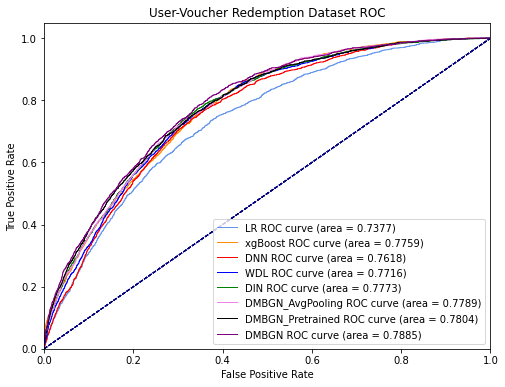

In [65]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
fpr = dict()
tpr = dict()
roc_auc = dict()

i = 0
lw = 1

colors = ["cornflowerblue", "darkorange", "red", "blue", "green", "violet", "black", "purple", "olive", "cyan"]


for model_name, (model, res, pred1, test_label1) in results.items():
    fpr[i], tpr[i], _ = roc_curve(test_label1.astype(int),  pred1)
    roc_auc = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=lw, label = model_name + ' ROC curve (area = ' + str(round(roc_auc, 4)) + ')')

    i += 1
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plt.title('User-Voucher Redemption Dataset ROC')
plt.legend(loc="lower right")
plt.show()

In [66]:
def relaImpr(a, b):
    x = ((a-0.5)/(b-0.5) - 1.0)*100.0
    return str("%.2f" % x) + '%'

dnn_auc = results['DNN'][1]['eval_auc']
din_auc = results['DIN'][1]['eval_auc']

table = PrettyTable(['Model','AUC','RelaImpr(DNN)','RelaImpr(DIN)', 'Logloss'], digits = 4, rounds=True)
for model_name, (model, res, pred1, test_label1) in results.items():
    table.add_row([model_name, "%.4f" % res['eval_auc'], relaImpr(res['eval_auc'], dnn_auc), relaImpr(res['eval_auc'], din_auc), "%.4f" % res['eval_logloss']])
print(table)

+------------------+--------+---------------+---------------+---------+
|      Model       |  AUC   | RelaImpr(DNN) | RelaImpr(DIN) | Logloss |
+------------------+--------+---------------+---------------+---------+
|        LR        | 0.7377 |     -9.22%    |    -14.28%    |  0.3897 |
|     xgBoost      | 0.7759 |     5.40%     |     -0.48%    |  0.3640 |
|       DNN        | 0.7618 |     0.00%     |     -5.57%    |  0.3775 |
|       WDL        | 0.7716 |     3.73%     |     -2.05%    |  0.3717 |
|       DIN        | 0.7773 |     5.90%     |     0.00%     |  0.3688 |
| DMBGN_AvgPooling | 0.7789 |     6.54%     |     0.61%     |  0.3684 |
| DMBGN_Pretrained | 0.7804 |     7.11%     |     1.14%     |  0.3680 |
|      DMBGN       | 0.7885 |     10.20%    |     4.06%     |  0.3616 |
+------------------+--------+---------------+---------------+---------+


Note that xgBoost has a higher AUC compared to DNN and WDL, mainly due to the small sample size.

# Reference

- [1] H Brendan McMahan, Gary Holt, David Sculley, Michael Young, Dietmar Ebner,Julian Grady, Lan Nie, Todd Phillips, Eugene Davydov, Daniel Golovin, et al.2013.  Ad click prediction: a view from the trenches. InProceedings of the 19thACM SIGKDD international conference on Knowledge discovery and data mining.1222–1230.
- [2] Guolin Ke, Qi Meng, Thomas Finley, Taifeng Wang, Wei Chen, Weidong Ma,Qiwei Ye, and Tie-Yan Liu. 2017. Lightgbm: A highly efficient gradient boostingdecision tree.Advances in neural information processing systems30 (2017), 3146–3154.
- [3] Heng-Tze Cheng, Levent Koc, Jeremiah Harmsen, Tal Shaked, Tushar Chandra,Hrishi Aradhye, Glen Anderson, Greg Corrado, Wei Chai, Mustafa Ispir, RohanAnil, Zakaria Haque, Lichan Hong, Vihan Jain, Xiaobing Liu, and Hemal Shah.2016. Wide & Deep Learning for Recommender Systems.CoRRabs/1606.07792(2016). arXiv:1606.07792  http://arxiv.org/abs/1606.07792 .
- [4] Guorui Zhou, Xiaoqiang Zhu, Chenru Song, Ying Fan, Han Zhu, Xiao Ma, YanghuiYan, Junqi Jin, Han Li, and Kun Gai. 2018. Deep interest network for click-throughrate prediction. InProceedings of the 24th ACM SIGKDD International Conferenceon Knowledge Discovery & Data Mining. 1059–1068.